# Creating dataset and descriptive stats

##### This notebook contains code to look at the questionnaire data of the study on voice-hearing in expert ayahuasca users

##### Created by Ana Hoban, last updated: febuary 4th 2025

# Imports and other important stuff

In [48]:
import numpy as np
import pandas as pd
import xlrd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
from collections import Counter
import csv
import datetime as dt
import re
from wordcloud import WordCloud


# set date and time for written output file
NOW = dt.datetime.now().strftime("%H-%M-%S")

# to be able to remove emojis in written answers
text = u'This dog \U0001f602'

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)


## Plotting settings

In [49]:
#plotting settings

# Set global figure size
plt.rcParams["figure.figsize"] = (12, 6)  # Width x Height in inches

# Set global font size
plt.rcParams["font.size"] = 14

# Set default color cycle for plots
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=[mcolors.CSS4_COLORS['rosybrown']])

# Grid and background settings
plt.rcParams["axes.grid"] = True  # Enable grid
plt.rcParams["grid.alpha"] = 0.5  # Grid transparency
plt.rcParams["axes.facecolor"] = "#f7f7f7"  # Light background

# Bar chart settings
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1.2

# Tick settings
plt.rcParams["xtick.direction"] = "out"
plt.rcParams["ytick.direction"] = "out"

# Enable tight layout globally
plt.rcParams["figure.autolayout"] = True


## Preliminaries: import data set, get list of question

In [50]:
#import data
raw_data = pd.read_excel("DATA/Ayahuasca Questionnaire total.xlsx", header = 0) 
questions = raw_data.iloc[0,24:]

#keep questions, RecordedDate, ResponseId, Finished, Duration
list(raw_data.keys())
to_drop = ['StartDate',
 'EndDate',
 'Status',
 'IPAddress',
 'RecipientLastName',
 'RecipientFirstName',
 'RecipientEmail',
 'ExternalReference',
 'LocationLatitude',
 'LocationLongitude',
 'DistributionChannel',
 'UserLanguage',
 'Q113']


#store questions
#the questions start at the 12th column
question_dict = dict([ (i+12,n)  for i,n in enumerate(questions)])

#store the dict in a file so its easier to find the questions
with open('question_index.txt', 'w') as my_file:
    [ my_file.write(f'{i, question_dict[i]}\n') for i in question_dict ]
    
raw_data = raw_data.drop(index = 0)
raw_data.head()

#instantiate a list of questions to keep for later
list_written_answers = []



In [51]:
#raw_data['IPAddress'].describe()
#raw_data['StartDate']
119-84

35

## Functions

In [52]:
def print_answers(col):
    #prints answers and appends the number of the question to a list
    
    # Print each answer with a blank line after
    #[print(i, '\n') for i in list(final_data.iloc[:, col].dropna())]

    # Append to file instead of overwriting
    list_written_answers.append(col)
    

In [53]:
def plot_ordered_histogram(df, col, rotate_labels=True, figsize=(10, 5), labels = None, title = None):
    """
    Plots a histogram (bar chart) of a categorical column with sorted labels, dropping NaN values.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col (int or str): The column index or name.
    rotate_labels (bool): Whether to rotate x-axis labels for better visibility.
    figsize (tuple): Figure size in inches (width, height).
    
    Returns:
    None
    """
    # Drop NaN values from the column
    valid_data = df.iloc[:,col].dropna()

    # Convert to categorical with sorted order
    if labels == None:
        valid_data = pd.Categorical(valid_data, categories=sorted(df.iloc[:,col].dropna().unique()), ordered=True)
    else:
        valid_data = pd.Categorical(valid_data, categories= labels, ordered=True)

        
    # Count occurrences in sorted order (fill missing values with 0)
    counts = valid_data.value_counts().reindex(valid_data.categories, fill_value=0)
    print(counts)

    # Set figure size
    plt.figure(figsize=figsize)

    # Plot bar chart
    bars = plt.bar(counts.index, counts.values)

    # Add labels to bars
    plt.bar_label(bars)

    # Rotate labels if necessary
    if rotate_labels:
        plt.xticks(rotation=45)

    # Show the plot
    if title is None:
        plt.title(question_dict[col])
    else:
        plt.title(title)
    plt.show()
    

def count_keywords_and_plot(df, col, sep=":", top_n=10, figsize=(15, 10), labels=None, drop_words=None, title = None):
    """
    Counts unique words in a column and plots a histogram of the top N words.
    If predefined labels are given, only those words will be counted.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col (int or str): The column index or name.
    sep (str): The separator used to split values in each row.
    top_n (int): Number of top words to display in the histogram.
    figsize (tuple): Figure size in inches (width, height).
    labels (list or set): A predefined list of words to count.
    drop_words (list or set): Words to exclude from the count.

    Returns:
    Counter: A dictionary-like object with word counts.
    """
    if drop_words is None:
        drop_words = set()  # Ensure it's a set for fast lookups

    # Drop NaN values and join all text into one large string
    text = sep.join(df.iloc[:, col].dropna().astype(str))  # Use the separator

    # Use regex to split words and normalize to lowercase
    words = re.findall(r'\b\w+\b', text.lower())  # Extract words

    # Filter out unwanted words
    filtered_words = [word for word in words if word not in drop_words]

    # Count occurrences of each remaining word
    word_counts = Counter(filtered_words)

    # If predefined labels exist, filter the counts to only include those words
    if labels:
        word_counts = {word: word_counts[word] for word in labels if word in word_counts}

    # Get top N most common words
    most_common = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    if not most_common:
        print("No words left after filtering!")
        return word_counts

    labels, counts = zip(*most_common)  # Split into labels and counts

    # Plot bar chart
    plt.figure(figsize=figsize)
    bars = plt.bar(labels, counts)

    # Add labels to bars
    plt.bar_label(bars)

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.xlabel("Keywords")
    plt.ylabel("Frequency")
    if title is None:
        plt.title(f"Keyword Frequency in Question {col}")
    else:
        plt.title(title)
    plt.show()

    return word_counts  # Return full word count dictionary if needed

def compare_before_after_hist(df, before_col, after_col, sep=",", top_n=10, figsize=(15, 10), labels=None, drop_words=None):
    """
    Compares answer distributions for two questions (before & after an event) 
    and plots a grouped histogram.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    before_col (int or str): The column index or name for "before" responses.
    after_col (int or str): The column index or name for "after" responses.
    sep (str): The separator used to split multiple answers in each row.
    top_n (int): Number of top answers to display in the histogram.
    figsize (tuple): Figure size in inches (width, height).
    labels (list or set): A predefined set of valid answers (filters the count to only include these).
    drop_words (list or set): Answers to exclude from the count.

    Returns:
    dict: Two Counter objects with answer counts for before and after.
    """
    if drop_words is None:
        drop_words = set()  # Ensure it's a set for fast lookups

    def process_column(col):
        """Helper function to count individual responses from a column."""
        responses = df.iloc[:,col].dropna().astype(str)
        all_answers = [ans.strip() for response in responses for ans in response.split(sep)]
        filtered_answers = [ans for ans in all_answers if ans not in drop_words]
        answer_counts = Counter(filtered_answers)

        if labels:
            answer_counts = {ans: answer_counts[ans] for ans in labels if ans in answer_counts}

        return answer_counts

    # Process "before" and "after" separately
    before_counts = process_column(before_col)
    after_counts = process_column(after_col)

    # Get top N most common answers from both columns
    all_answers = set(before_counts.keys()).union(set(after_counts.keys()))
    if labels:
        all_answers = all_answers.intersection(labels)
    
    most_common = sorted(all_answers, key=lambda x: before_counts.get(x, 0) + after_counts.get(x, 0), reverse=True)[:top_n]

    if not most_common:
        print("No valid answers left after filtering!")
        return before_counts, after_counts

    before_values = [before_counts.get(ans, 0) for ans in most_common]
    after_values = [after_counts.get(ans, 0) for ans in most_common]

    # Plot bar chart
    x = range(len(most_common))
    width = 0.4  # Bar width

    plt.figure(figsize=figsize)
    bars1 = plt.bar(x, before_values, width=width, label="After", color="blue", alpha=0.7)
    bars2 = plt.bar([i + width for i in x], after_values, width=width, label="During", color="red", alpha=0.7)

    # Add labels to bars
    plt.bar_label(bars1)
    plt.bar_label(bars2)

    # Set x-axis labels
    plt.xticks([i + width / 2 for i in x], most_common, rotation=45, ha="right")

    # Show the plot
    plt.xlabel("Answers")
    plt.ylabel("Frequency")
    plt.title(question_dict[before_col])
    plt.legend()
    plt.show()

    return before_counts, after_counts  # Return both dictionaries if needed

In [54]:
#v2
def compare_before_after_hist(df, before_col, after_col, sep=",", top_n=10, figsize=(18, 8), labels=None, drop_words=None, title = None):
    """
    Compares answer distributions for two questions (before & after an event) 
    and plots:
      1. Count-based histogram (absolute values)
      2. Frequency-based histogram (percentage)

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    before_col (int or str): The column index or name for "before" responses.
    after_col (int or str): The column index or name for "after" responses.
    sep (str): The separator used to split multiple answers in each row.
    top_n (int): Number of top answers to display in the histograms.
    figsize (tuple): Figure size in inches (width, height).
    labels (list or set): A predefined set of valid answers (filters the count to only include these).
    drop_words (list or set): Answers to exclude from the count.

    Returns:
    dict: Two Counter objects with answer counts for before and after.
    """
    if drop_words is None:
        drop_words = set()  # Ensure it's a set for fast lookups

    def process_column(col):
        """Helper function to count individual responses from a column."""
        responses = df.iloc[:,col].dropna().astype(str)
        all_answers = [ans.strip() for response in responses for ans in response.split(sep)]
        filtered_answers = [ans for ans in all_answers if ans not in drop_words]
        answer_counts = Counter(filtered_answers)

        if labels:
            answer_counts = {ans: answer_counts[ans] for ans in labels if ans in answer_counts}

        return answer_counts

    # Process "before" and "after" separately
    before_counts = process_column(before_col)
    after_counts = process_column(after_col)

    # Get total counts for normalization
    total_before = sum(before_counts.values())
    total_after = sum(after_counts.values())

    # Get top N most common answers from both columns
    all_answers = set(before_counts.keys()).union(set(after_counts.keys()))
    if labels:
        all_answers = all_answers.intersection(labels)
    
    most_common = sorted(all_answers, key=lambda x: before_counts.get(x, 0) + after_counts.get(x, 0), reverse=True)[:top_n]

    if not most_common:
        print("No valid answers left after filtering!")
        return before_counts, after_counts

    # Compute values for count and frequency
    before_values = [before_counts.get(ans, 0) for ans in most_common]
    after_values = [after_counts.get(ans, 0) for ans in most_common]

    before_freq = [count / total_before * 100 if total_before > 0 else 0 for count in before_values]
    after_freq = [count / total_after * 100 if total_after > 0 else 0 for count in after_values]

    x = np.arange(len(most_common))
    width = 0.4  # Bar width

    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # **Plot 1: Count Comparison**
    axes[0].bar(x, before_values, width=width, label="After",color=mcolors.CSS4_COLORS['rosybrown'],alpha=0.7)
    axes[0].bar(x + width, after_values, width=width, label="During", color=mcolors.CSS4_COLORS['goldenrod'],alpha=0.7)

    # Add labels to bars
    axes[0].bar_label(axes[0].containers[0])
    axes[0].bar_label(axes[0].containers[1])

    axes[0].set_xticks(x + width / 2)
    axes[0].set_xticklabels(most_common, rotation=45, ha="right")
    axes[0].set_xlabel("Answers")
    axes[0].set_ylabel("Count")
    axes[0].set_title(f"Question {question_dict[before_col]} (Count)")
    if title != None:
        axes[0].set_title(f"{title} (Count)")
    axes[0].legend()

    # **Plot 2: Frequency Comparison**
    axes[1].bar(x, before_freq, width=width, label="After (%)", color=mcolors.CSS4_COLORS['rosybrown'], alpha=0.7)
    axes[1].bar(x + width, after_freq, width=width, label="During (%)", color=mcolors.CSS4_COLORS['goldenrod'], alpha=0.7)

    # Add labels to bars
    axes[1].bar_label(axes[1].containers[0], fmt="%.3f%%")
    axes[1].bar_label(axes[1].containers[1], fmt="%.3f%%")

    axes[1].set_xticks(x + width / 2)
    axes[1].set_xticklabels(most_common, rotation=45, ha="right")
    axes[1].set_xlabel("Answers")
    axes[1].set_ylabel("Percentage")
    axes[1].set_title(f"Question {question_dict[before_col]} (Frequency)")
    if title != None:
        axes[1].set_title(f"{title} (Frequency)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return before_counts, after_counts  # Return both dictionaries if needed

In [55]:
def count_keywords_and_plot(df, col, sep=",", top_n=20, figsize=(15, 10), labels=None, drop_words=None, title=None):
    """
    Counts unique answers in a multiple-choice column (with multiple selections per row) 
    and plots a histogram of the top N answers.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col (int or str): The column index or name.
    sep (str): The separator used to split multiple answers in each row.
    top_n (int): Number of top answers to display in the histogram.
    figsize (tuple): Figure size in inches (width, height).
    labels (list or set): A predefined set of valid answers (filters the count to only include these).
    drop_words (list or set): Answers to exclude from the count.
    title (str): Custom title for the plot.

    Returns:
    Counter: A dictionary-like object with answer counts.
    """
    if drop_words is None:
        drop_words = set(['  ', 'religious'])  # Ensure it's a set for fast lookups

    # Drop NaN values and convert all to lowercase strings
    responses = df.iloc[:, col].dropna().astype(str)

    # Step 1: Split answers & CLEAN properly
    all_answers = []
    for response in responses:
        # Remove non-breaking spaces & weird characters
        cleaned_response = re.sub(r'\s+', ' ', response).strip()
        # Split using the given separator & clean individual answers
        split_answers = [ans.strip(",").lower() for ans in cleaned_response.split(sep)]
        all_answers.extend(split_answers)

    # Step 2: Filter out unwanted words
    filtered_answers = [ans.replace(':', '') for ans in all_answers if ans not in drop_words]

    # Step 3: Count occurrences
    answer_counts = Counter(filtered_answers)

    # Step 4: Filter predefined labels (if provided)
    if labels:
        labels = {label.lower().strip(",") for label in labels} # Normalize labels
        answer_counts = {ans: answer_counts[ans] for ans in labels if ans in answer_counts}

    # Step 5: Get top N answers
    most_common = sorted(answer_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    if not most_common:
        print("No valid answers left after filtering!")
        return answer_counts

    labels, counts = zip(*most_common)  # Split into labels and counts

    # Step 6: Plot
    plt.figure(figsize=figsize)
    
    bars = plt.bar(labels, counts)

    # Add labels to bars
    plt.bar_label(bars)

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha="right")

    # Show the plot
    plt.xlabel("Answers")
    plt.ylabel("Frequency")
    plt.title(title if title else f"Top {top_n} Answers in Question {col}")
    plt.show()

    return answer_counts  # Return full answer count dictionary if needed



## Updated functions

In [56]:
def plot_ordered_histogram(df, col, rotate_labels=True, figsize=(10, 5), labels=None, title=None):
    """
    Plots both a count and a frequency histogram for a categorical column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col (int or str): The column index or name.
    rotate_labels (bool): Whether to rotate x-axis labels for better visibility.
    figsize (tuple): Figure size in inches (width, height).
    
    Returns:
    None
    """
    # Drop NaN values from the column
    valid_data = df.iloc[:, col].dropna()

    # Convert to categorical with sorted order
    if labels is None:
        labels = sorted(valid_data.unique())
    valid_data = pd.Categorical(valid_data, categories=labels, ordered=True)

    # Count occurrences
    counts = valid_data.value_counts().reindex(valid_data.categories, fill_value=0)
    frequencies = counts / counts.sum()  # Normalize to get frequencies

    # Set up figure with two subplots (Counts and Frequency)
    fig, axes = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]))

    # Plot raw counts
    bars = axes[0].bar(counts.index, counts.values)
    axes[0].bar_label(bars)
    axes[0].set_xlabel("Categories")
    axes[0].set_ylabel("Count")
    #axes[0].set_title(title if title else f"Counts for {question_dict[col]}")

    # Plot frequencies
    bars_freq = axes[1].bar(frequencies.index, frequencies.values)
    axes[1].bar_label(bars_freq, fmt="%.4f")  # Show 2 decimal places
    axes[1].set_xlabel("Categories")
    axes[1].set_ylabel("Frequency")
    
    
    #axes[1].set_title(title if title else f"Frequencies for {question_dict[col]}")

    # Rotate labels if needed
    if rotate_labels:
        for ax in axes:
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45, ha="right")

    # Show plot
    #plt.tight_layout()
    fig.suptitle(title if title else f"Counts for {question_dict[col]}", size= 16)
    plt.show()
    
    
def count_keywords_and_plot(df, col, sep=":", top_n=10, figsize=(15, 10), labels=None, drop_words=None, title=None):
    """
    Counts unique words in a column and plots both count and frequency histograms.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col (int or str): The column index or name.
    sep (str): The separator used to split values in each row.
    top_n (int): Number of top words to display in the histogram.
    figsize (tuple): Figure size in inches (width, height).
    labels (list or set): A predefined list of words to count.
    drop_words (list or set): Words to exclude from the count.

    Returns:
    Counter: A dictionary-like object with word counts.
    """
    if drop_words is None:
        drop_words = set()  # Ensure it's a set for fast lookups

    # Drop NaN values and join all text into one large string
    text = sep.join(df.iloc[:, col].dropna().astype(str))

    # Use regex to split words and normalize to lowercase
    words = re.findall(r'\b\w+\b', text.lower())

    # Filter out unwanted words
    filtered_words = [word for word in words if word not in drop_words]

    # Count occurrences of each remaining word
    word_counts = Counter(filtered_words)

    # If predefined labels exist, filter the counts to only include those words
    if labels:
        word_counts = {word: word_counts[word] for word in labels if word in word_counts}

    # Get top N most common words
    most_common = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

    if not most_common:
        print("No words left after filtering!")
        return word_counts

    labels, counts = zip(*most_common)  # Split into labels and counts
    frequencies = [c / sum(counts) for c in counts]  # Normalize to get frequencies

    # Set up figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]))

    # Plot raw counts
    bars = axes[0].bar(labels, counts)
    axes[0].bar_label(bars, size = 20)
    axes[0].set_xlabel("Keywords", size=20)
    axes[0].set_ylabel("Count", size=20)
    #axes[0].set_title(title if title else f"Counts for {question_dict[col]}", size=16)

    # Plot frequencies
    bars_freq = axes[1].bar(labels, frequencies)
    axes[1].bar_label(bars_freq, fmt="%.2f")
    axes[1].set_xlabel("Keywords", size=20)
    axes[1].set_ylabel("Frequency", size=20)
    #axes[1].set_title(title if title else f"Frequencies for {question_dict[col]}", size=16)

    # Rotate labels for readability
    for ax in axes:
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right", size=20)
    
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=10)

    plt.tight_layout()
    fig.suptitle(title if title else f"Counts for {question_dict[col]}", size= 16)
    plt.show()

    return word_counts  # Return full word count dictionary if needed

## Data cleaning


<AxesSubplot:>

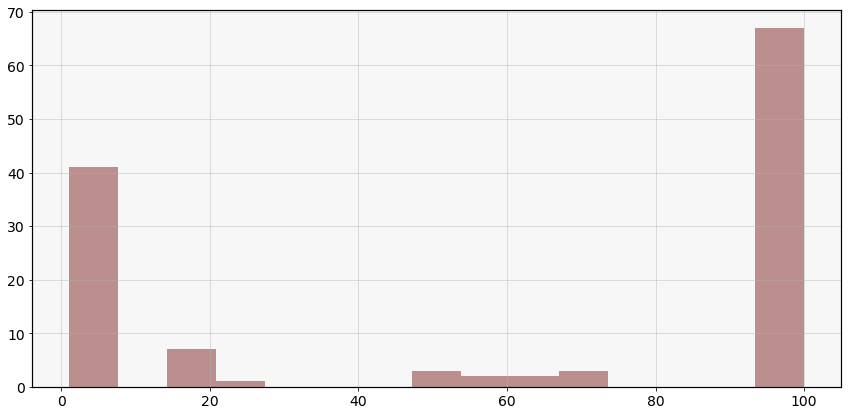

In [57]:
raw_data['Progress'].hist(bins=15)

In [58]:
#keep only questionnaires that were finished
keep_data = raw_data.loc[raw_data['Progress'] >= 3].drop(columns = to_drop) 
len(keep_data)

85

In [59]:
raw_data.loc[raw_data['Progress'] == 2].iloc[:,:20]


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,RecipientFirstName,RecipientEmail,ExternalReference,LocationLatitude,LocationLongitude,DistributionChannel,UserLanguage,Q4,Q5,Q6
26,2020-05-04 07:10:12,2020-05-04 07:10:18,IP Address,146.198.102.170,2,6,False,2020-05-11 07:10:35.298000,R_xacFLY7OGiALwAN,NaN,NaN,NaN,NaN,NaN,NaN,anonymous,EN,NaN,NaN,NaN


In [60]:
# exclusion criteria
# history of psychiatric diagnosis is question #17
#finished_data = finished_data[finished_data.iloc[:,17] == 'No'] 

#never took ayahuasca
exc_data = keep_data[keep_data.iloc[:,29] !='0']

#psych taken in last day
#exc_data = exc_data[exc_data.iloc[:,22] != 'In the last day']

#ayahuasca taken in last day
#exc_data = exc_data[exc_data.iloc[:,30] != 'In the last day']

print(len(keep_data) - len(exc_data), 'people were excluded')
final_data = exc_data

1 people were excluded


In [61]:
print(f'We have {len(final_data)} participants')
tot_finished= len(final_data[ final_data['Finished'] == 'True' ])
print(f'Out of those, {tot_finished} completed the entire questionnaire')

We have 84 participants
Out of those, 64 completed the entire questionnaire


In [62]:
final_data.to_csv('Data/clean_dataset.csv', encoding = 'UTF-8', index= False)

# Data

## General/background questions

#### Demographics

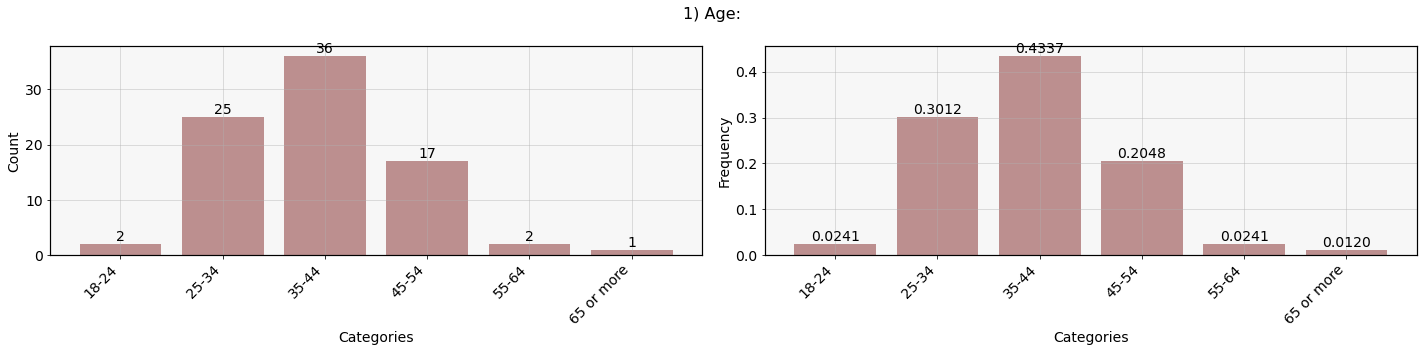

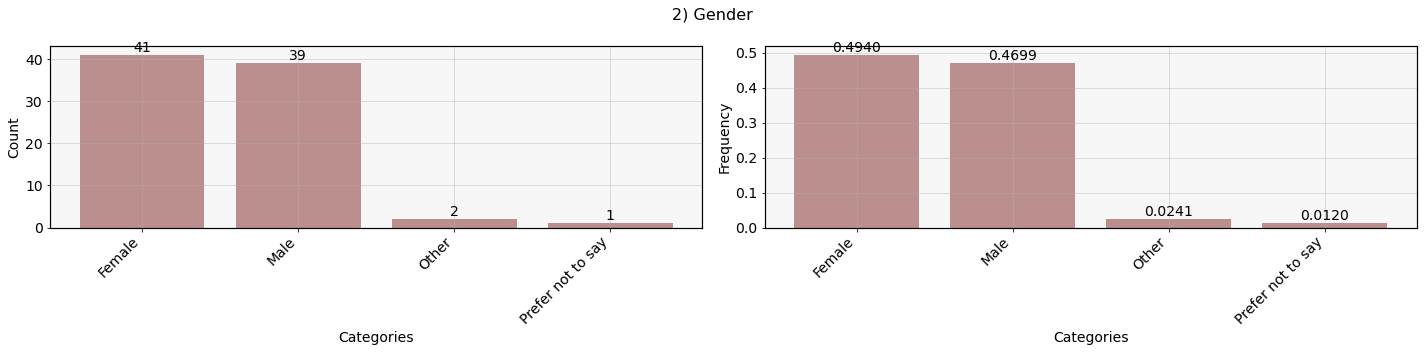

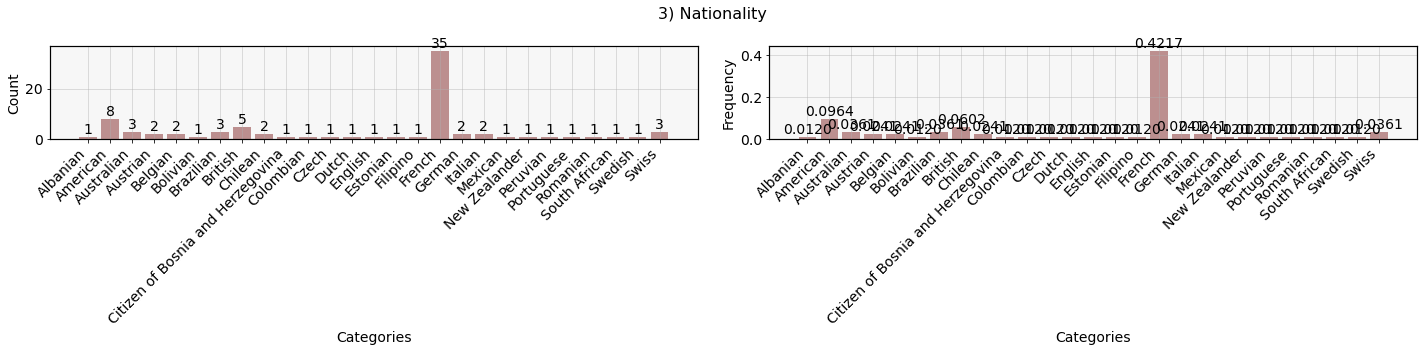

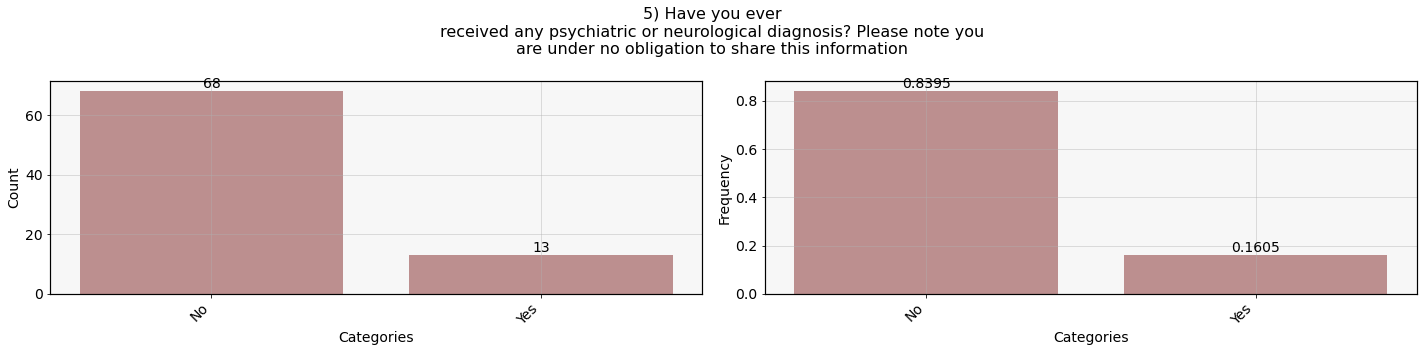

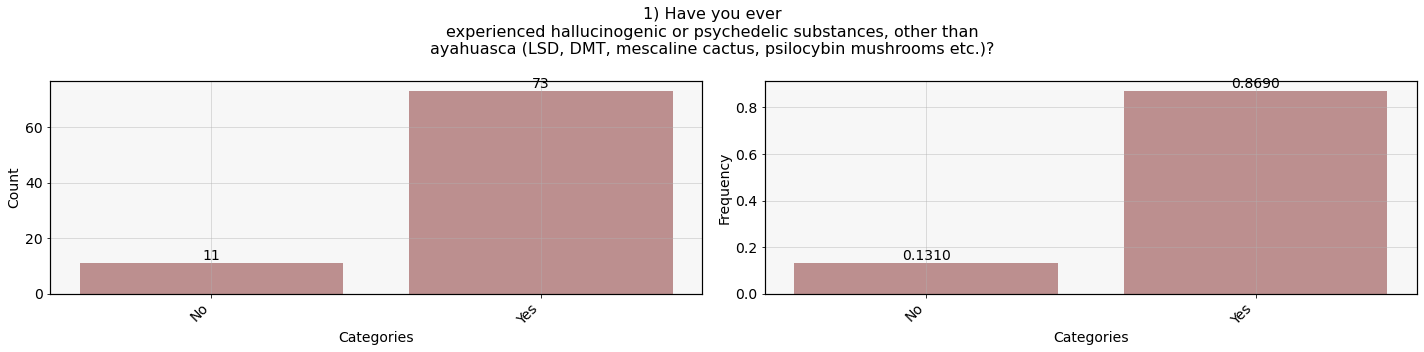

In [63]:
# Demographics
demo_quest = [12,13,14,17,19]
# Ensure categorical column is ordered
for i in demo_quest:
    plot_ordered_histogram(final_data, i, title = question_dict[i])  # Using column index

#### Other substances

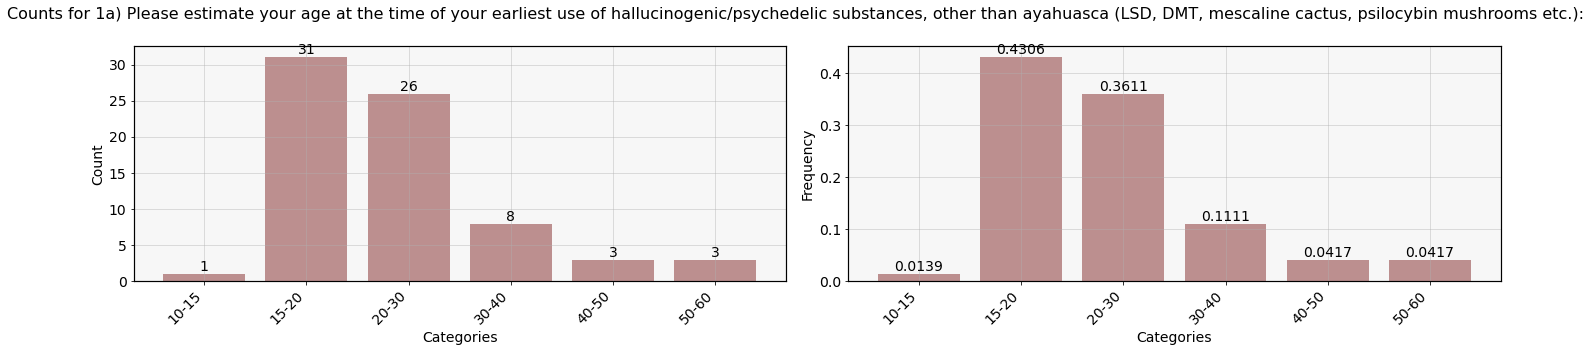

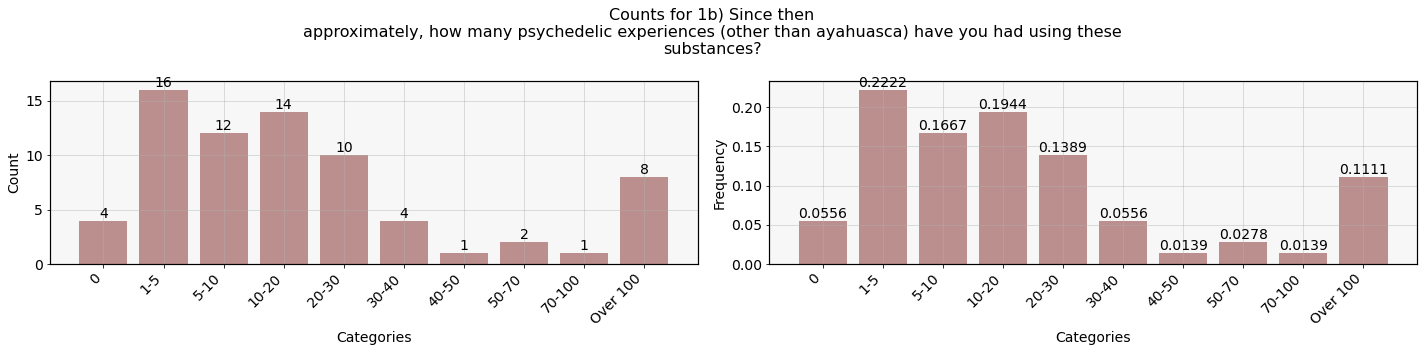

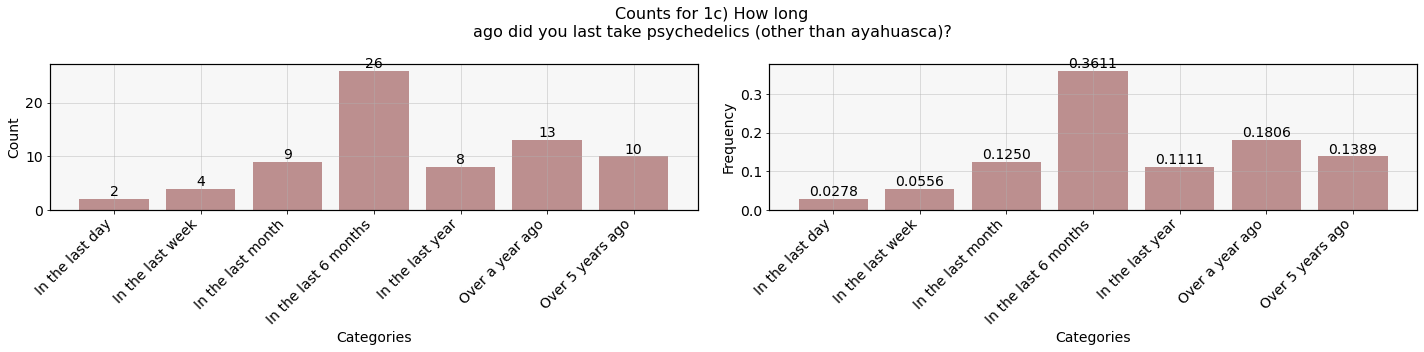

In [64]:
#other substances
other_quest = [20]
for i in other_quest:
    plot_ordered_histogram(final_data, i)  # Using column index

plot_ordered_histogram(final_data, 21, labels = ['0','1-5','5-10','10-20','20-30','30-40','40-50','50-70', '70-100','Over 100'])
plot_ordered_histogram(final_data, 22, labels = ['In the last day','In the last week', 'In the last month', 'In the last 6 months', 'In the last year','Over a year ago', 'Over 5 years ago'])

#### Baseline VH

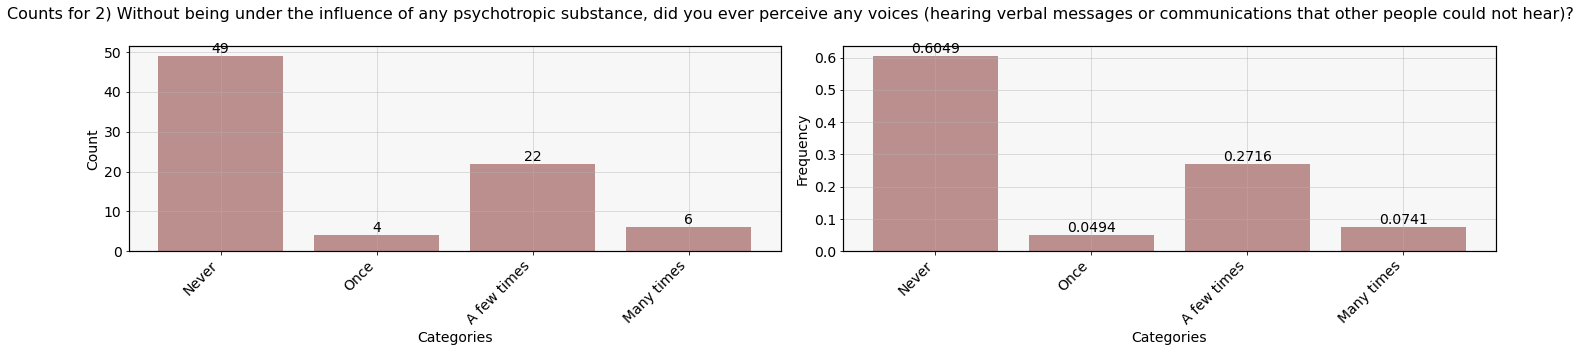

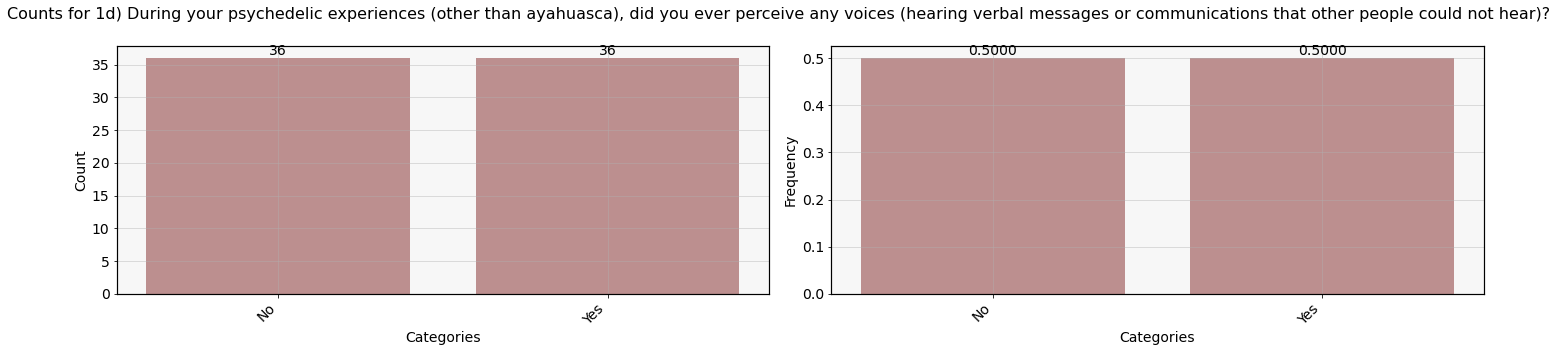

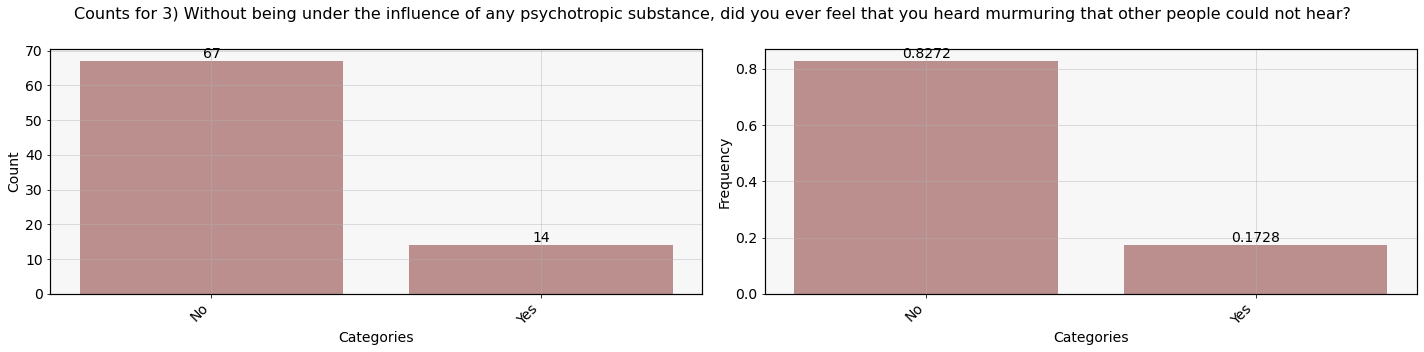

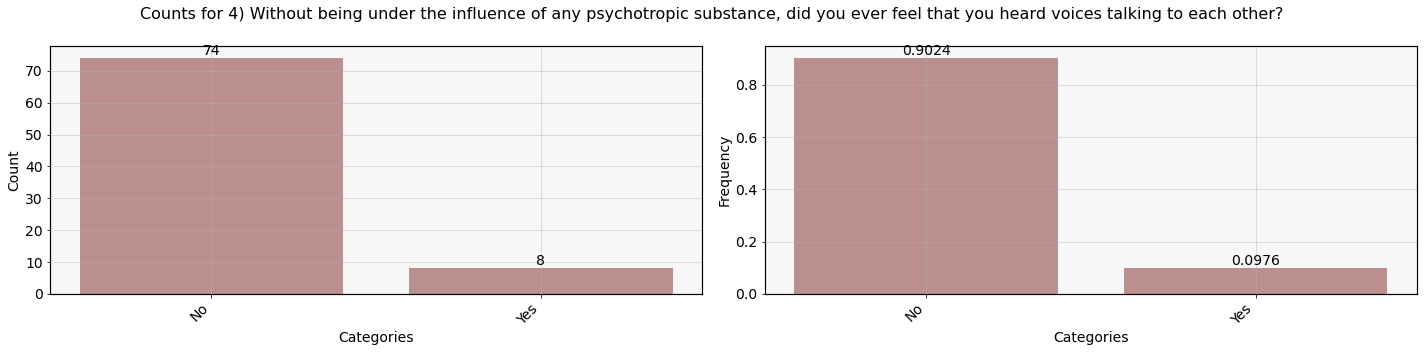

In [65]:
# baseline voice hearing
plot_ordered_histogram(final_data, 24, labels = ['Never','Once', 'A few times', 'Many times'])

vh_quest = [23,25,26]
for i in vh_quest:
    plot_ordered_histogram(final_data, i)  # Using column index

### Ayahuasca background

In [66]:
#ayahuasca introduction
print_answers(27)

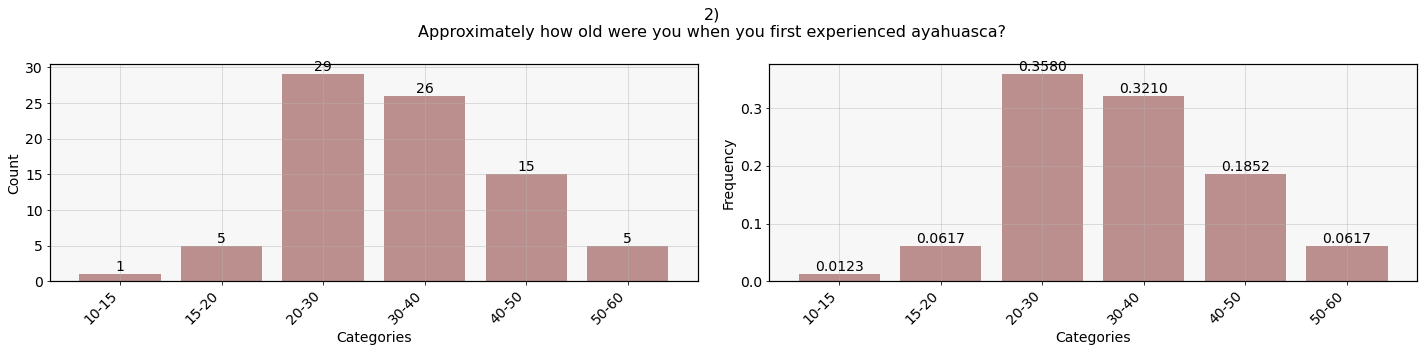

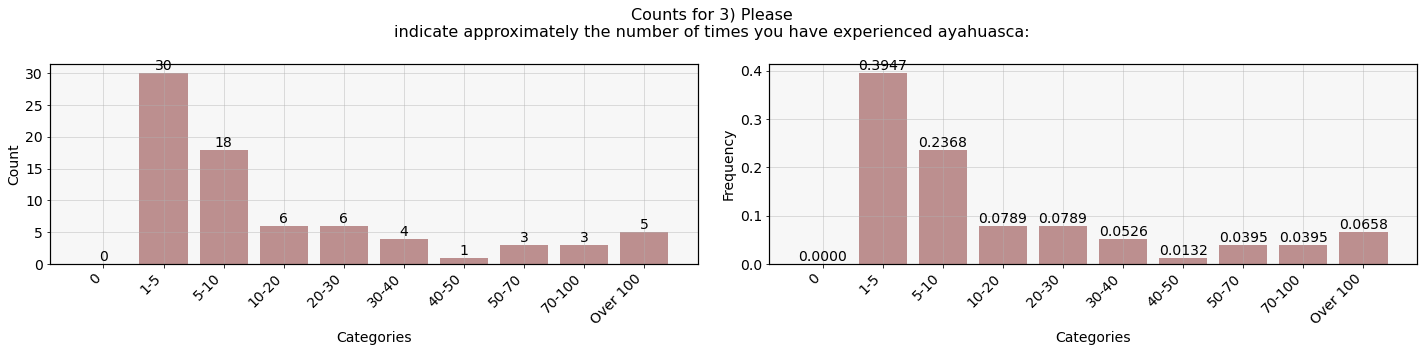

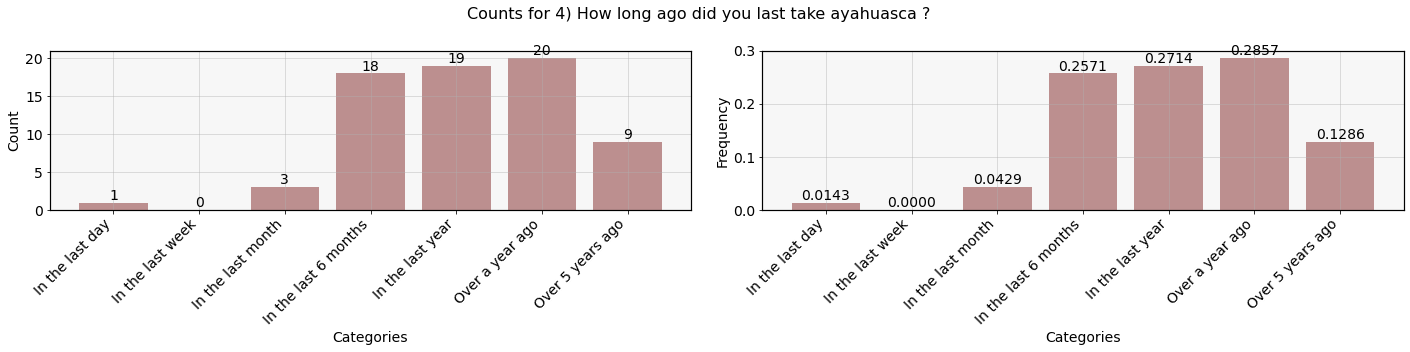

In [67]:
# ayahuasca basics
plot_ordered_histogram(final_data, 28, title = question_dict[28])  # Using column index
    
plot_ordered_histogram(final_data, 29, labels = ['0','1-5','5-10','10-20','20-30','30-40','40-50','50-70', '70-100','Over 100'])
plot_ordered_histogram(final_data, 30, labels = ['In the last day','In the last week', 'In the last month', 'In the last 6 months', 'In the last year','Over a year ago', 'Over 5 years ago'])

#### Ayahuasca - reasons

In [68]:

final_data.iloc[:,31].dropna()

1                 Ritual context :,Therapeutic context :
2           Ritual context :,Religious context :,Other :
3      Recreational context :,Ritual context :,Therap...
4      Recreational context :,Ritual context :,Religi...
5                                       Ritual context :
                             ...                        
114                                Therapeutic context :
118               Ritual context :,Therapeutic context :
119         Recreational context :,Therapeutic context :
121                 Ritual context :,Religious context :
126    Ritual context :,Religious context :,Therapeut...
Name: Q30, Length: 76, dtype: object

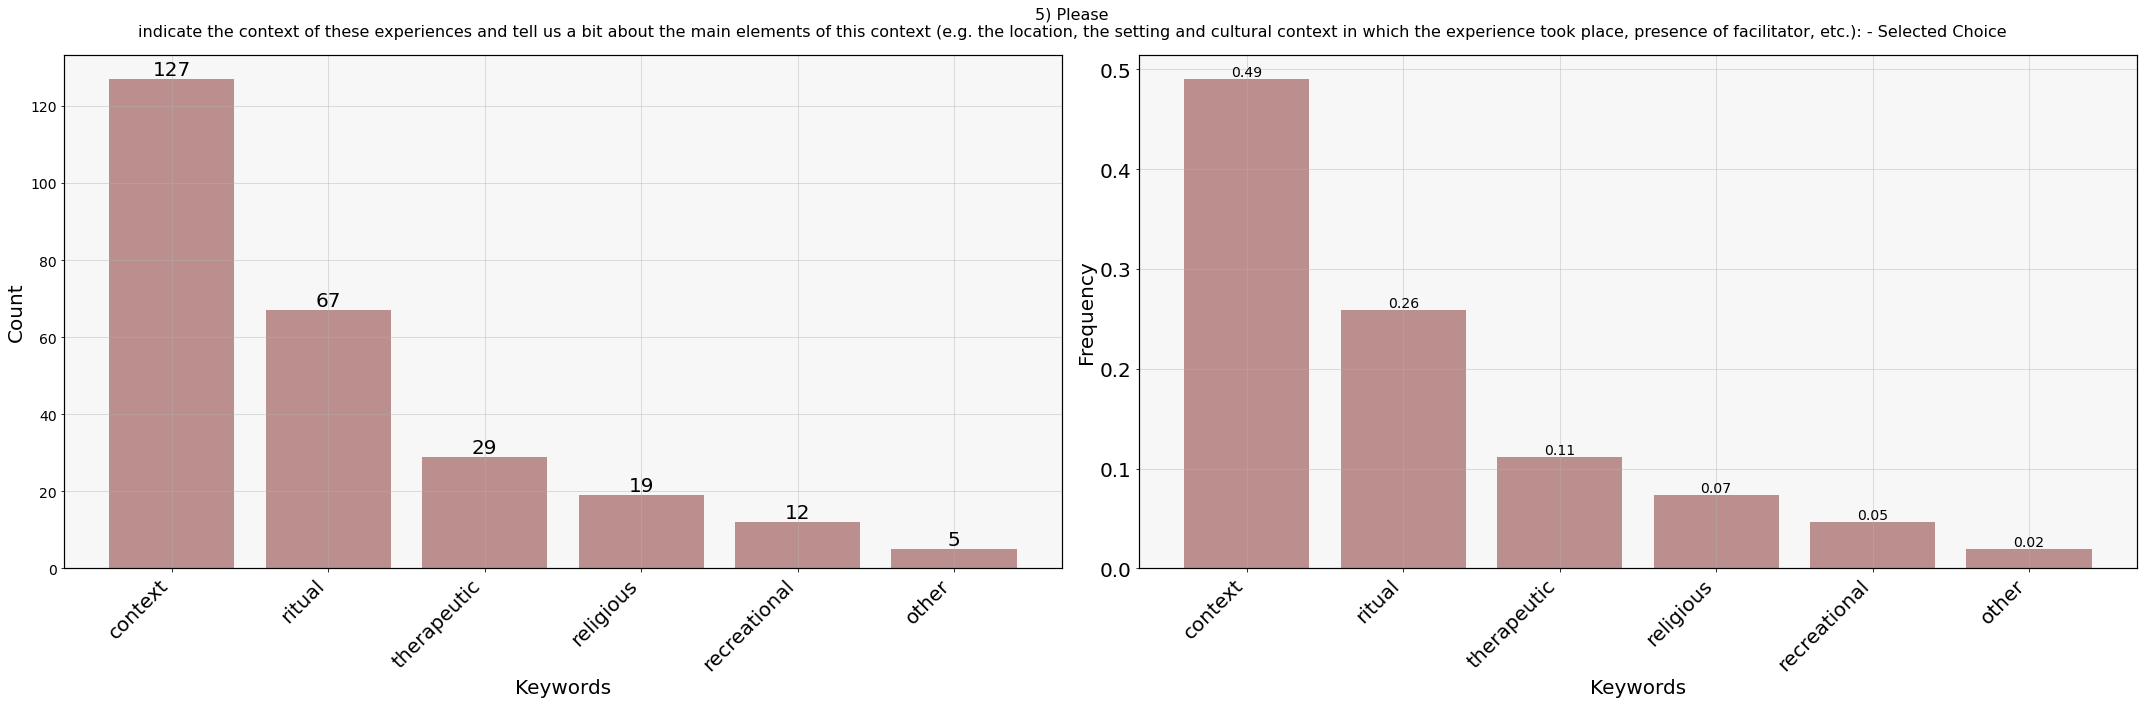

-----------recreational-----------


-----------ritual-----------


-----------religious-----------


-----------therapeutic-----------


-----------other-----------




In [69]:
#question 31: which context?
count_keywords_and_plot(final_data, 31 , sep=",", title = question_dict[31])


#for the next questions, it's details for each context:
#recreational 
for i, n in enumerate(['recreational','ritual', 'religious', 'therapeutic', 'other']):
    print(f'-----------{n}-----------')
    print_answers(i+32)
    print('\n')   


#### General questions - VH

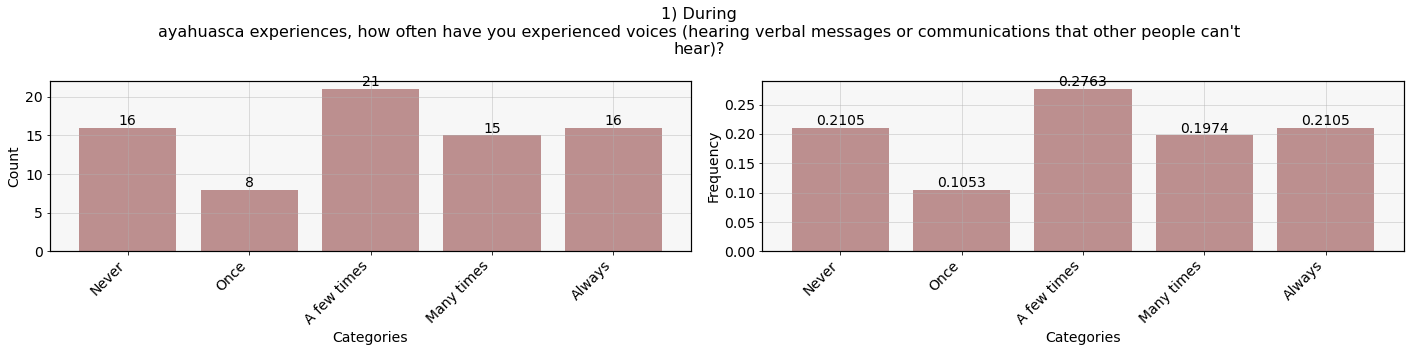

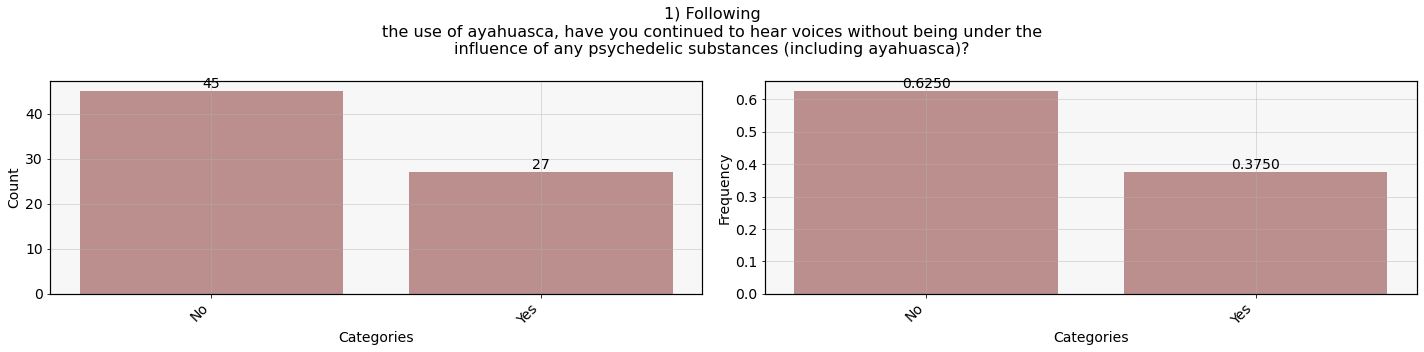

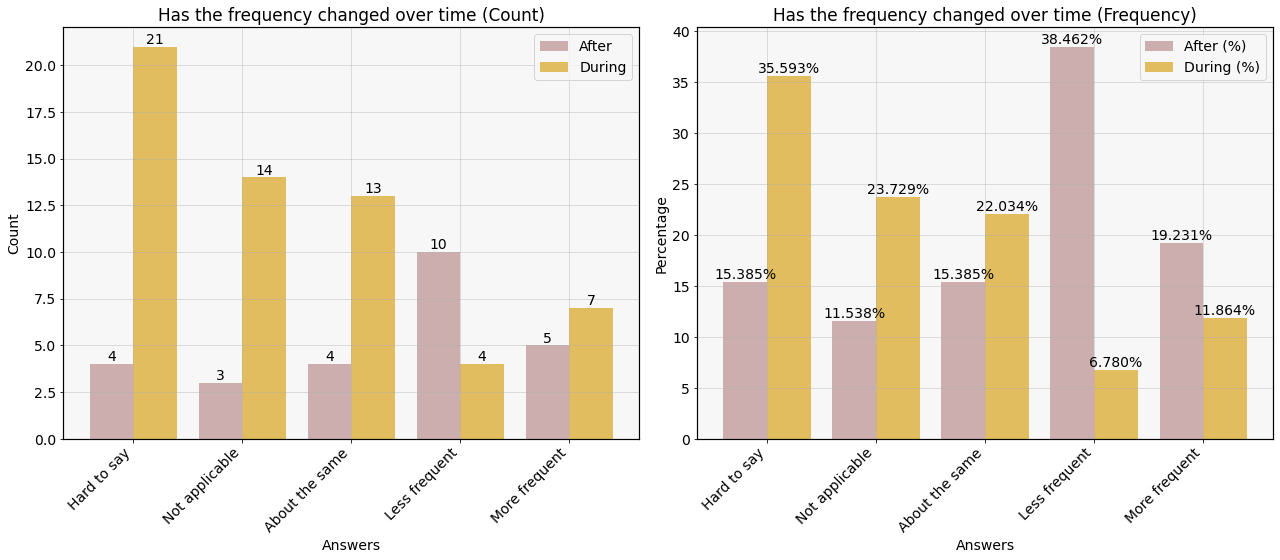

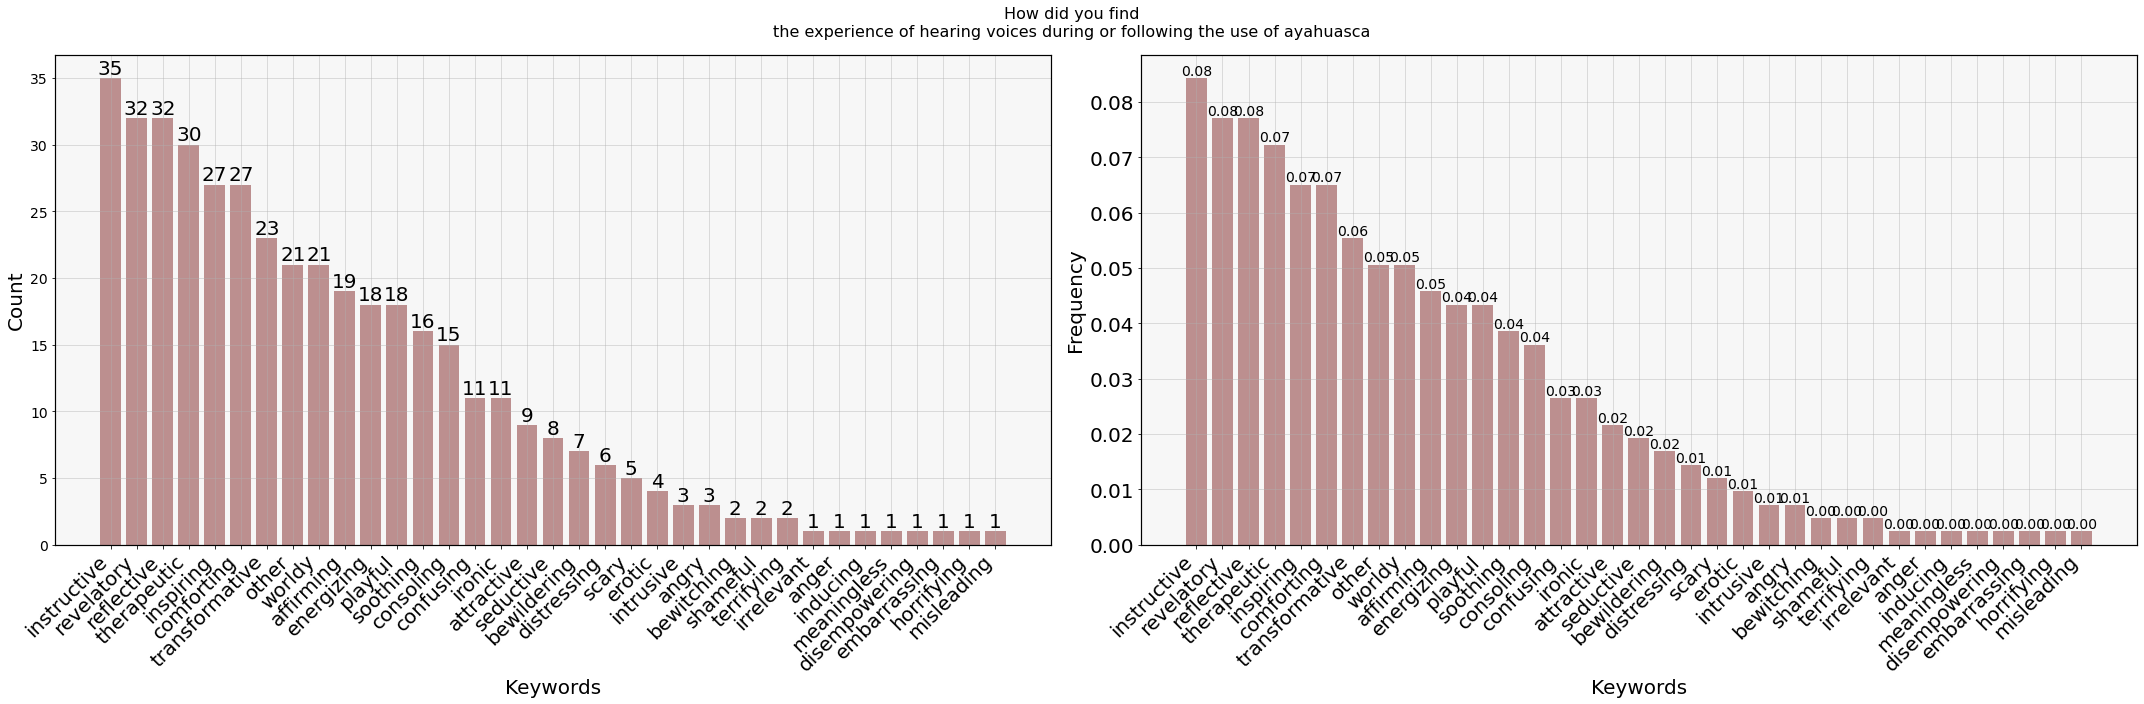

What has caused this change in frequency? AFTER ayahuasca
What has caused this change in frequency? DURING ayahuasca


In [70]:
likert_labs =  ['Never', 'Once', 'A few times', 'Many times', 'Always']
plot_ordered_histogram(final_data, 37, labels = likert_labs, title = question_dict[37])

plot_ordered_histogram(final_data, 38,title = question_dict[38])

compare_before_after_hist(final_data, 39, 88,title = 'Has the frequency changed over time')

count_keywords_and_plot(final_data, 87, title = 'How did you find\nthe experience of hearing voices during or following the use of ayahuasca', top_n=65)

print( 'What has caused this change in frequency? AFTER ayahuasca' )
print_answers(40)

print( 'What has caused this change in frequency? DURING ayahuasca' )
print_answers(89)

In [71]:
final_data.iloc[:, 87]

1      Inspiring,Therapeutic,Transformative,Consoling...
2           Instructive,Inspiring,Bewildering,Irrelevant
3      Comforting,Instructive,Inspiring,Revelatory,Af...
4      Instructive,Reflective,Revelatory,Confusing,In...
5      Comforting,Instructive,Therapeutic,Transformat...
                             ...                        
114                                                  NaN
118                                                  NaN
119    Distressing,Comforting,Instructive,Reflective,...
121    Instructive,Reflective,Inspiring,Therapeutic,R...
126    Distressing,Comforting,Instructive,Reflective,...
Name: Q54, Length: 84, dtype: object

In [72]:
#making a word cloud

# Drop NaN values and join all text into one large string
text = ':'.join(final_data.iloc[:, 87].dropna().astype(str))  # Use the separator
print('answers:', len(final_data.iloc[:, 87].dropna().astype(str)))

text = text.replace("other worldly", "other_worldly")
text = text.replace("anger inducing", "anger_inducing")

# Use regex to split words and normalize to lowercase, removing punctuation
# Remove non-alphanumeric and non-whitespace characters, then remove extra spaces
cleaned_text = re.sub(r'[^\w\s]', ' ', text.lower())
cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip() #remove extra spaces, and trailing/leading spaces.

# Use regex to split words
words = re.findall(r'\b\w+\b', cleaned_text)

# Count word frequencies
word_counts = Counter(words)

if "worldy" in word_counts:
    del word_counts["worldy"]
if "anger" in word_counts:
    del word_counts["anger"]


answers: 49


Counter Output: Counter({'instructive': 35, 'revelatory': 32, 'reflective': 32, 'therapeutic': 30, 'inspiring': 27, 'comforting': 27, 'transformative': 23, 'other': 21, 'affirming': 19, 'energizing': 18, 'playful': 18, 'soothing': 16, 'consoling': 15, 'confusing': 11, 'ironic': 11, 'attractive': 9, 'seductive': 8, 'bewildering': 7, 'distressing': 6, 'scary': 5, 'erotic': 4, 'intrusive': 3, 'angry': 3, 'bewitching': 2, 'shameful': 2, 'terrifying': 2, 'irrelevant': 1, 'inducing': 1, 'meaningless': 1, 'disempowering': 1, 'embarrassing': 1, 'horrifying': 1, 'misleading': 1})


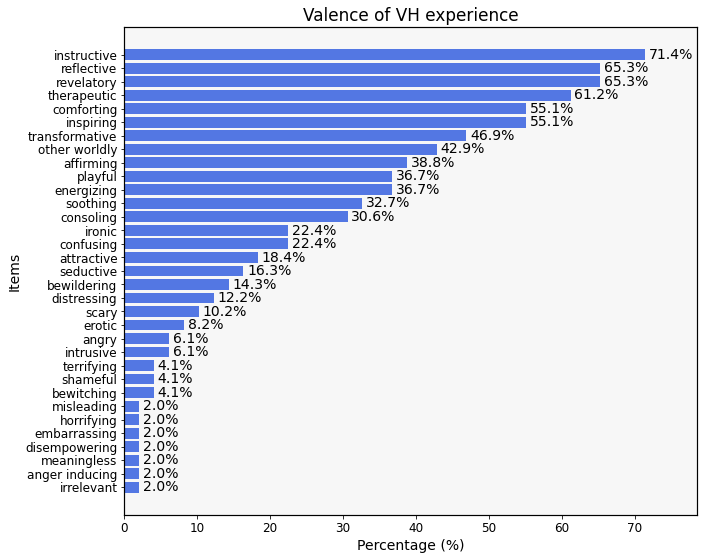

In [73]:

def create_horizontal_bar_chart_from_counter(counter_output, title="Distribution", color='skyblue'):
    """
    Generates a horizontal bar chart from the output of a Counter object,
    with the x-axis showing percentages.

    Args:
        counter_output (Counter): A Counter object containing items and their counts.
        title (str, optional): The title of the chart. Defaults to "Distribution".
        color (str, optional): The color of the bars. Defaults to 'skyblue'.
    """
    if not counter_output:
        print("Counter output is empty. Cannot create a chart.")
        return

    total_count = sum(counter_output.values())
    if total_count == 0:
        print("Total count is zero. Cannot calculate percentages.")
        return

    labels = list(counter_output.keys())
    counts = list(counter_output.values())
    percentages = [(count / 49) * 100 for count in counts]

    # Sort by percentage for better visualization
    sorted_indices = sorted(range(len(percentages)), key=lambda k: percentages[k])
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_labels_corr = [s.replace("other", "other worldly").replace('inducing', 'anger inducing') for s in sorted_labels]

    sorted_percentages = [percentages[i] for i in sorted_indices]
   
   
    plt.figure(figsize=(10, 8))  # Adjust figure size as needed
    plt.barh(sorted_labels_corr, sorted_percentages, color=color, alpha = 0.9)
    plt.xlim(0, sorted_percentages[-1] * 1.1)  # Add 10% padding
    plt.xlabel("Percentage (%)", fontsize = 14)
    plt.ylabel("Items", fontsize = 14)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.title(title)
    
     # Remove background grid lines
    plt.grid(False, axis='y') # Remove horizontal grid lines (behind the bars)
    plt.grid(False, axis='x') # Remove vertical grid lines
    # Add percentage labels to the bars
    for i, v in enumerate(sorted_percentages):
        plt.text(v + 0.5, i, f"{v:.1f}%", color='black', va='center')

    plt.tight_layout()
    plt.show()

print("Counter Output:", word_counts)

create_horizontal_bar_chart_from_counter(word_counts, title="Valence of VH experience", color='royalblue')



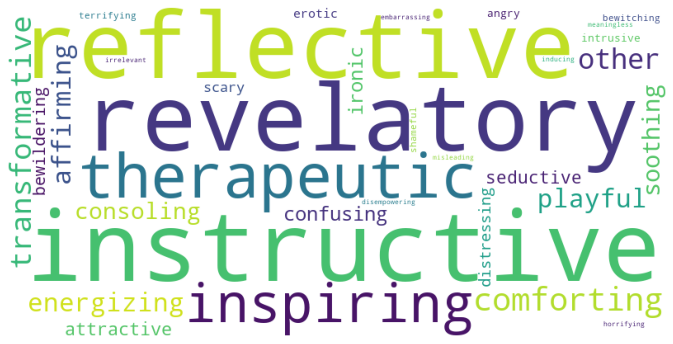

In [74]:
#plot the cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap = 'viridis').generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off') 
plt.show()

#### Phenomenology

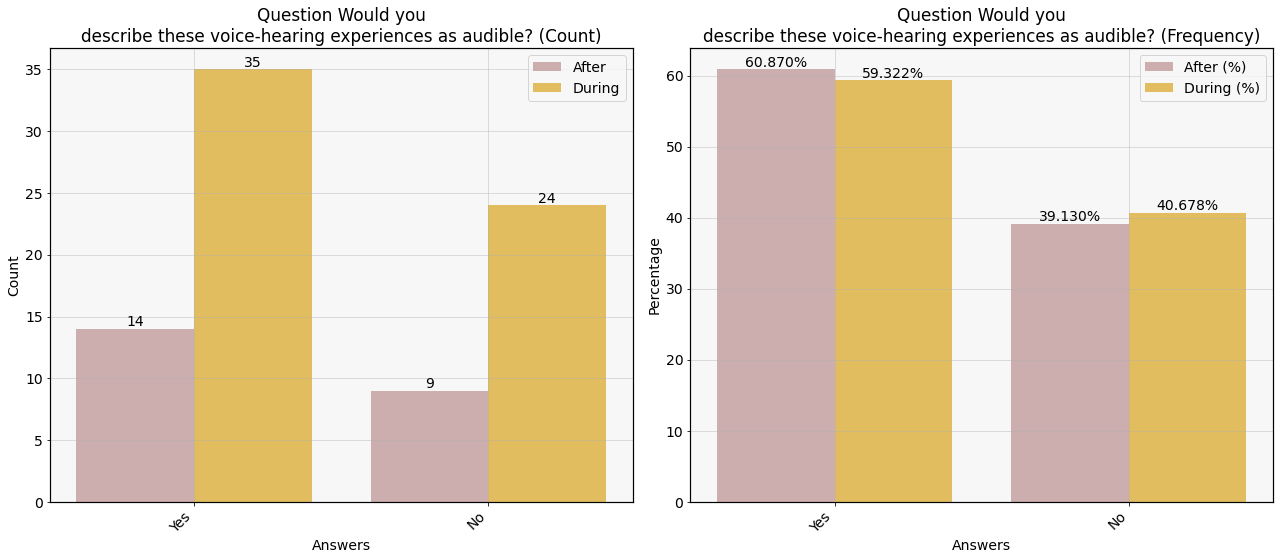

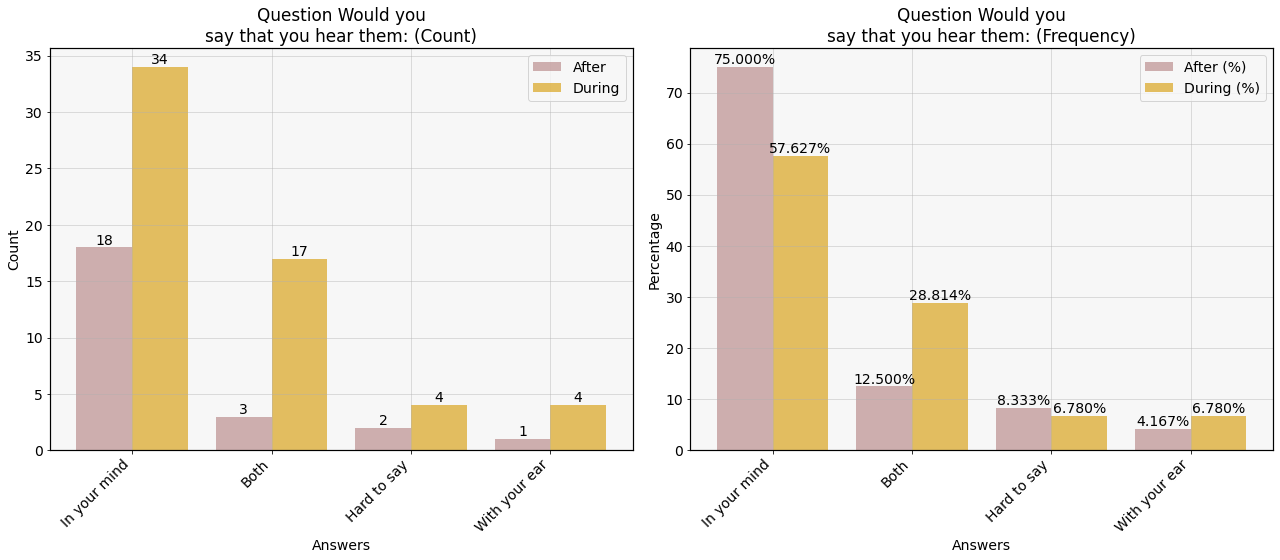

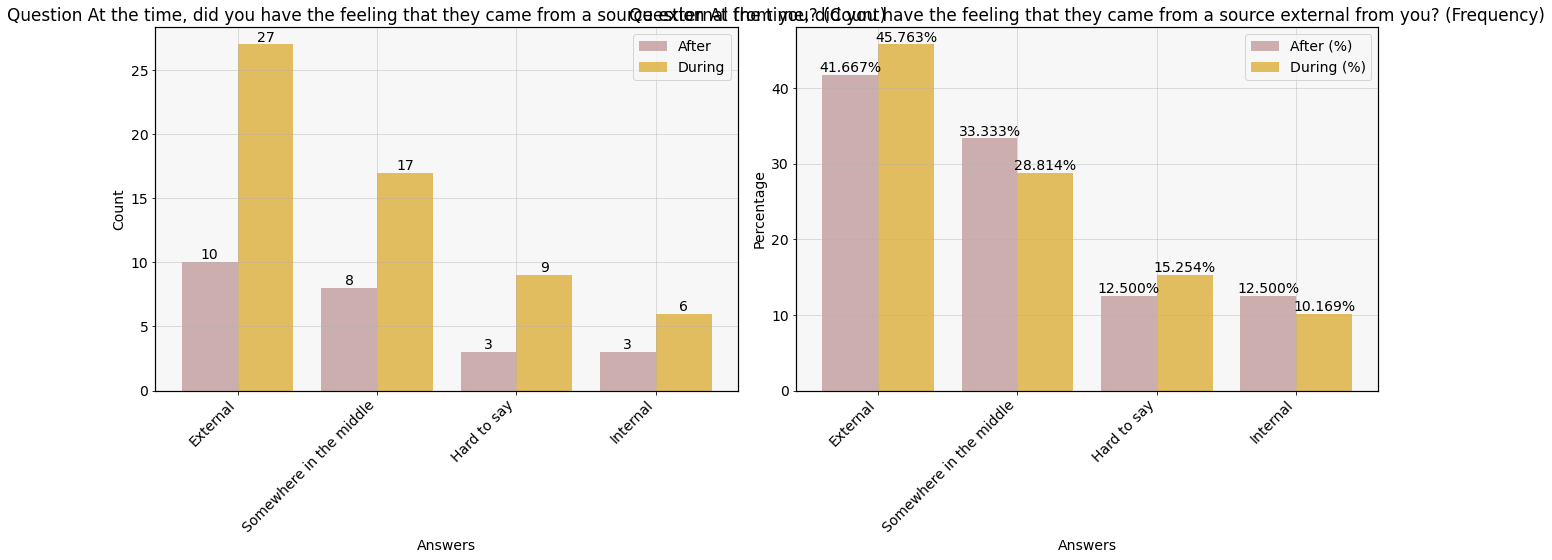

How do they differ from your own thoughts - AFTER
How do they differ from your own thoughts - DURING


In [75]:
#phenomenology
for i in [41,42,43]:
    compare_before_after_hist(final_data, i, i+49)
    
print('How do they differ from your own thoughts - AFTER')
print_answers(44)

print('How do they differ from your own thoughts - DURING')
print_answers(93)

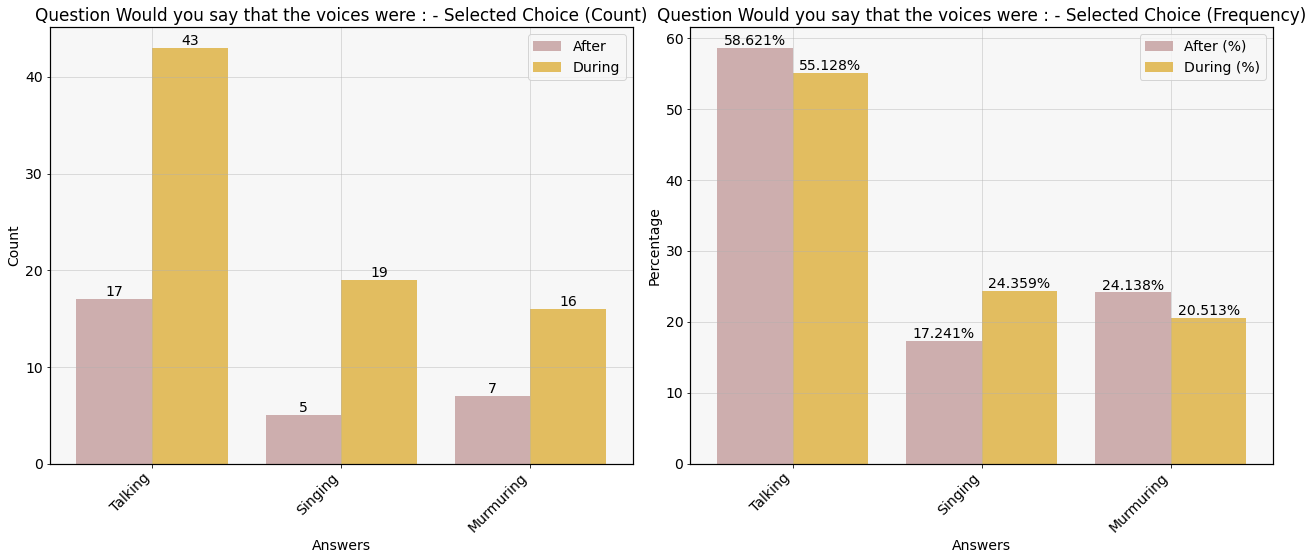

SPECIFY


In [76]:
#phenomenology
compare_before_after_hist(final_data, 45, 94, labels = {'Talking','Murmuring','Singing', 'Other (please specify)'})

#other
print('SPECIFY')
print_answers(46)
print_answers(95)

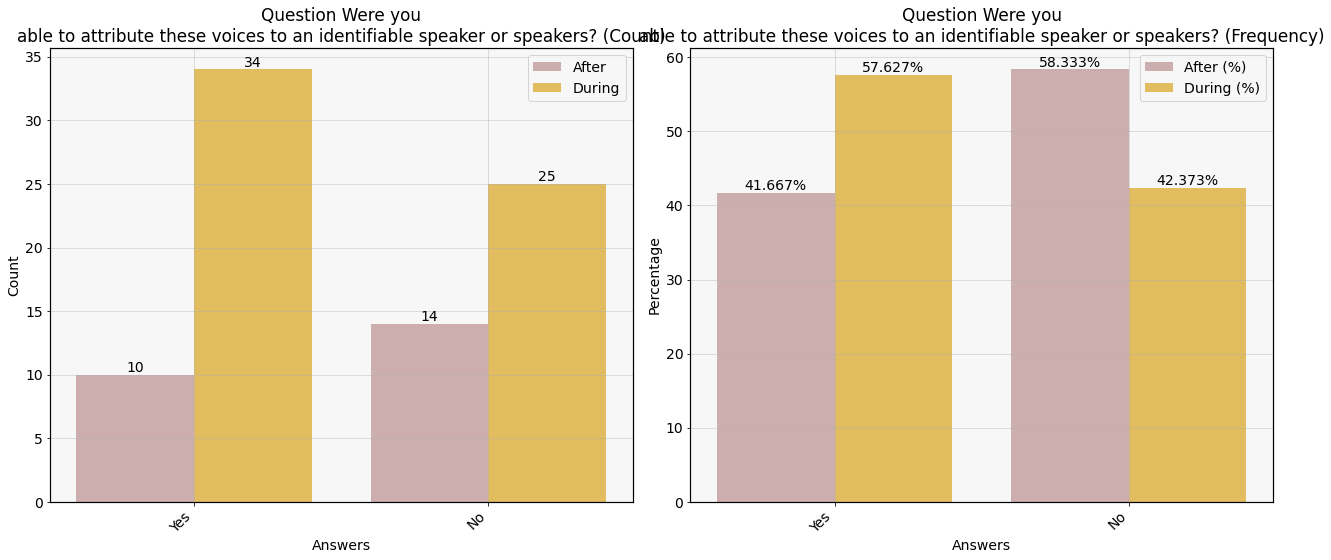

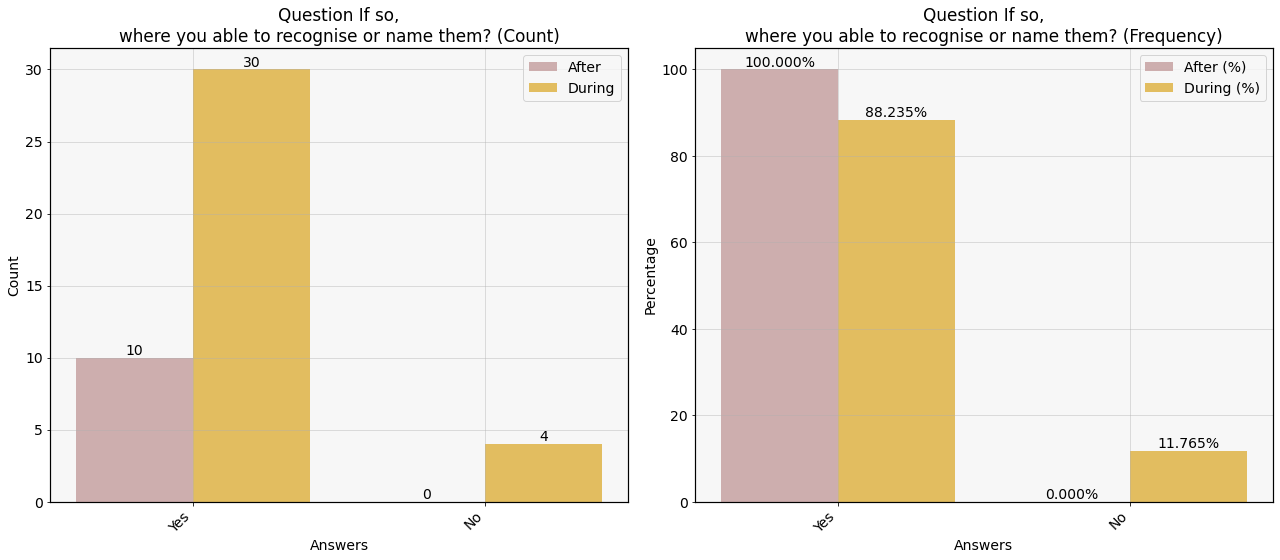

HOW DID YOU RECOGNIZE THEM?


In [77]:
#speaker
for i in [47,48]:
    compare_before_after_hist(final_data, i, i+49)

print('HOW DID YOU RECOGNIZE THEM?')    
print_answers(49)
print_answers(98)

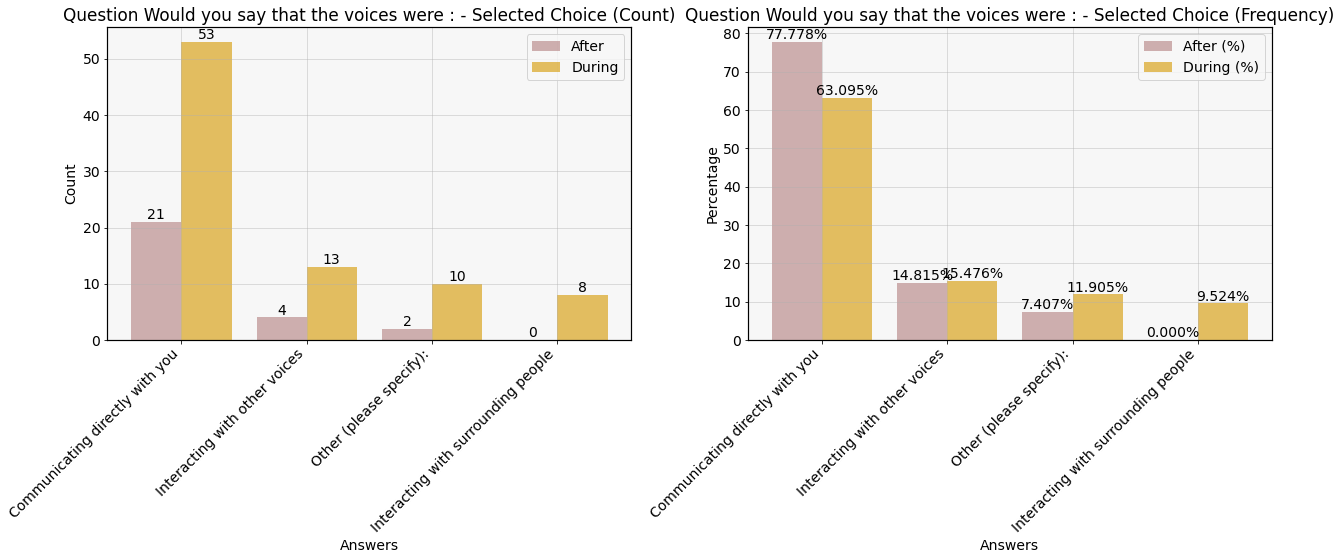

other: (after)
other: (during)


In [78]:
compare_before_after_hist(final_data, 50, 99)

#caracterizing the voices after ayahuasca
print('other: (after)')
print_answers(51)

print('other: (during)')
print_answers(100)

#### Context

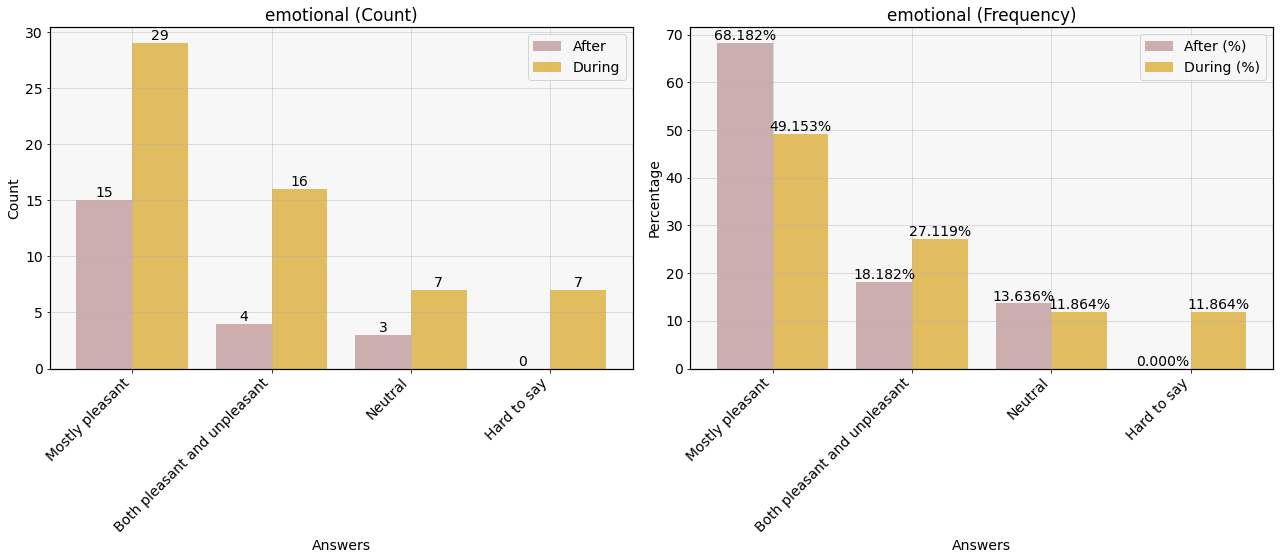

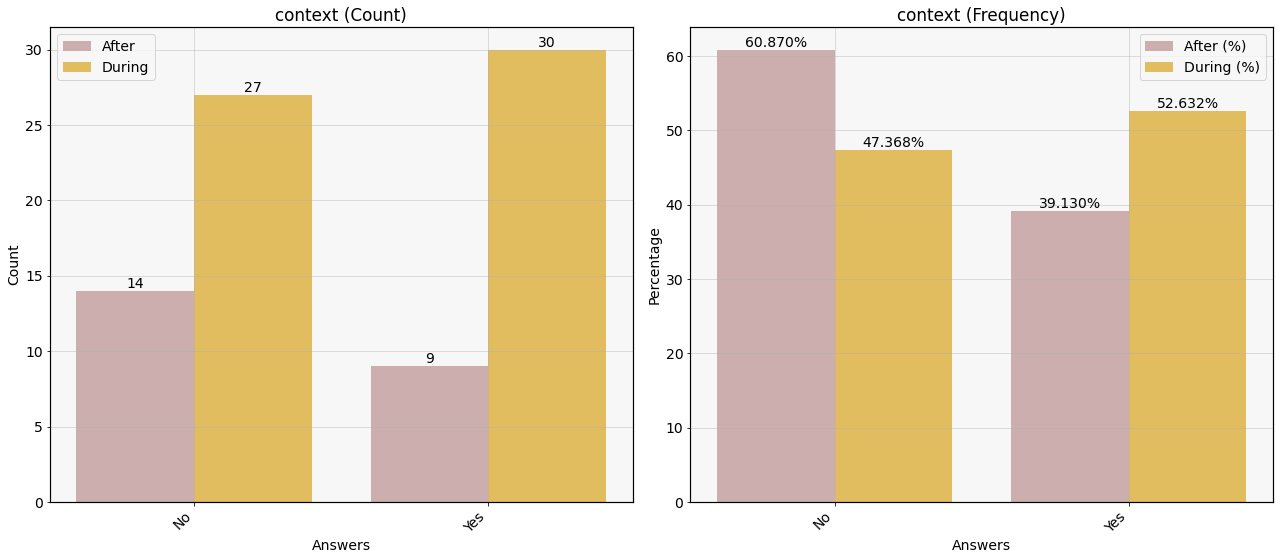

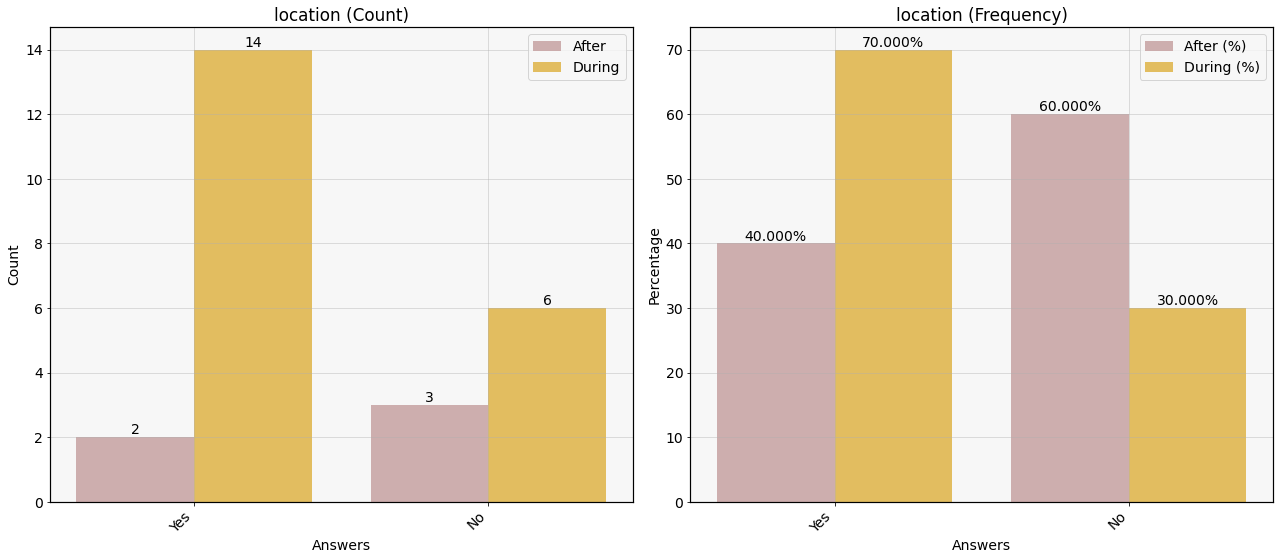

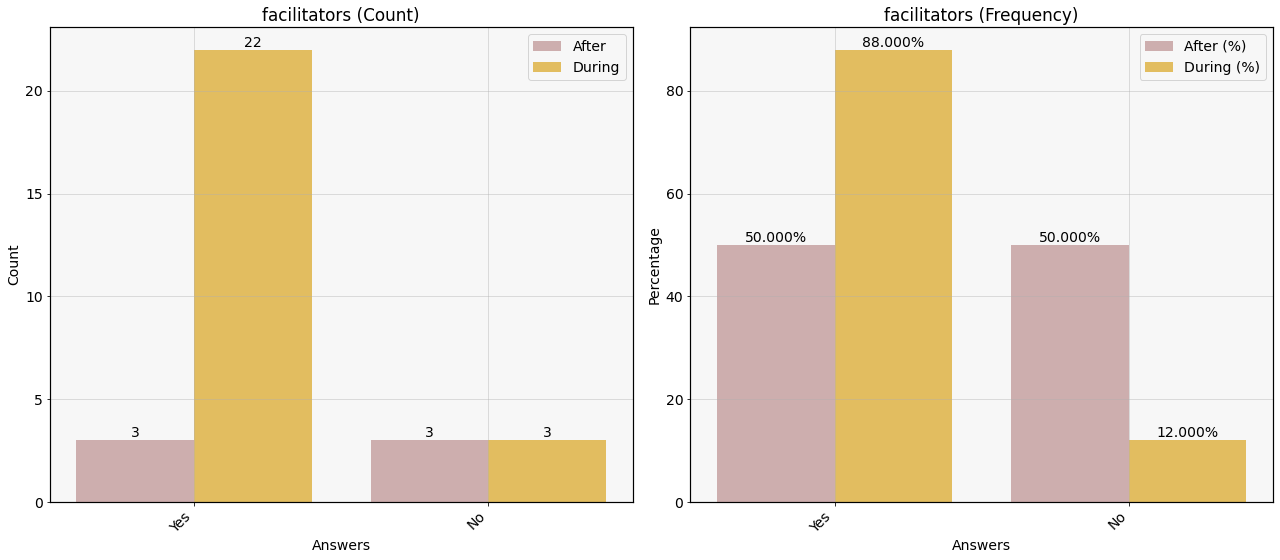

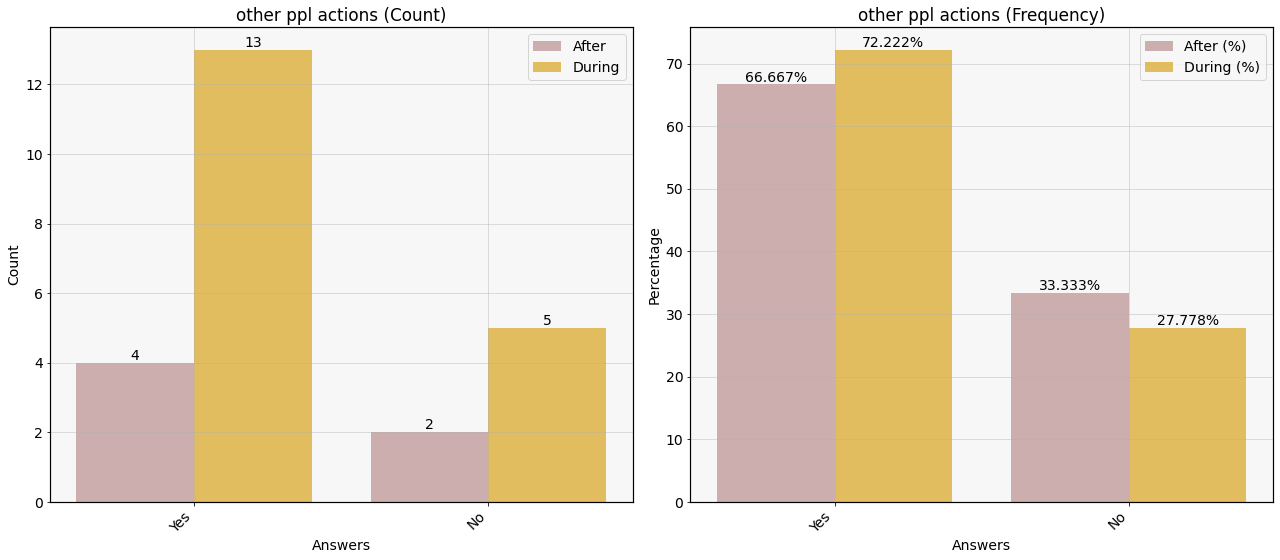

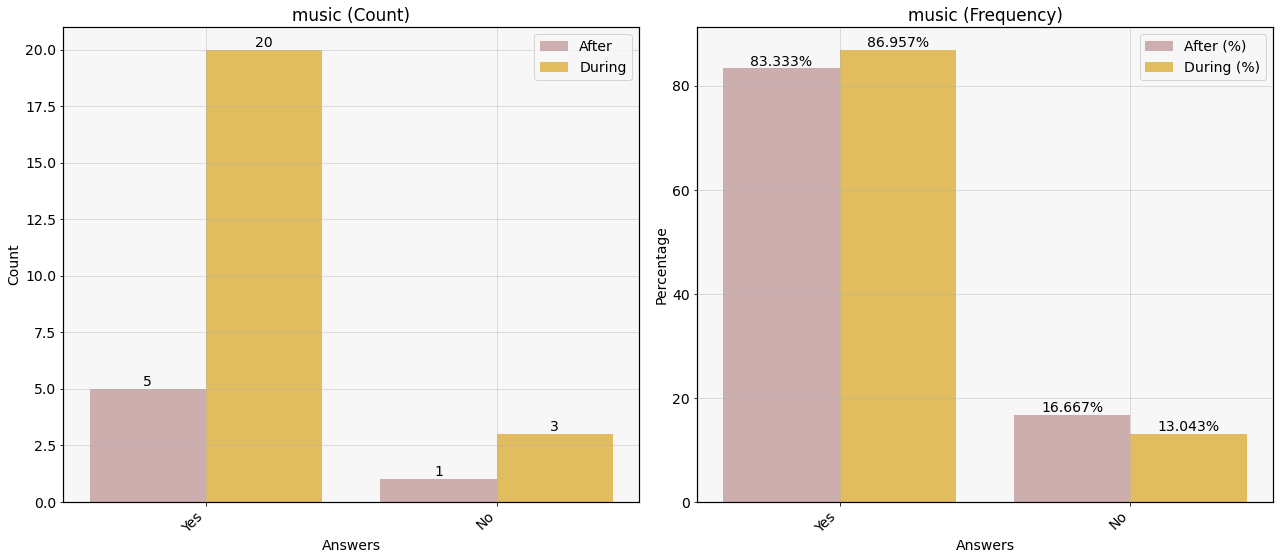

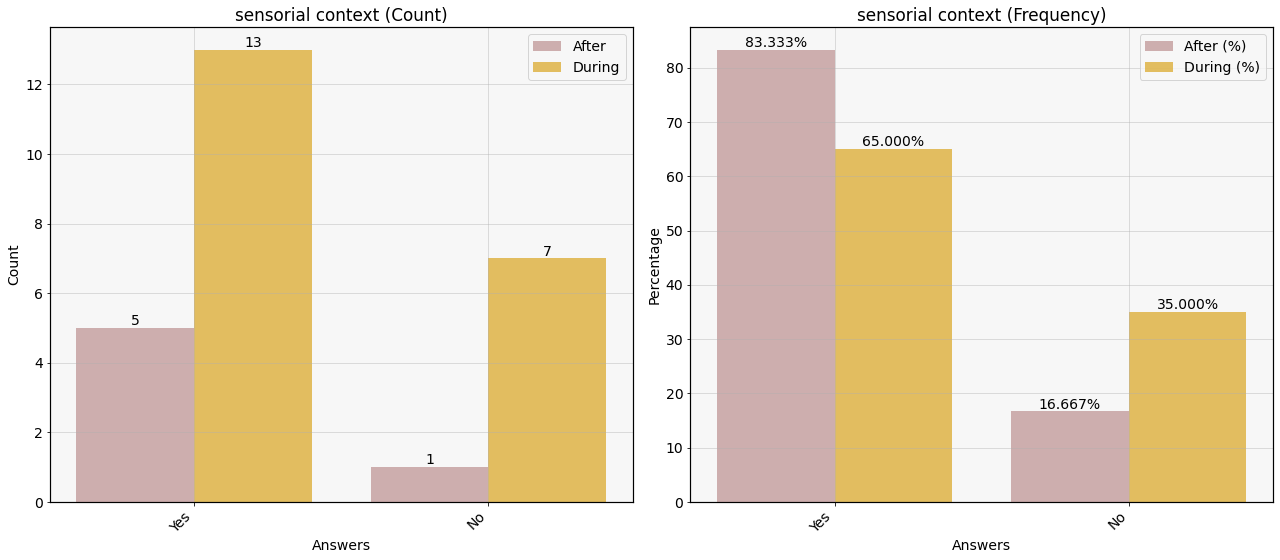

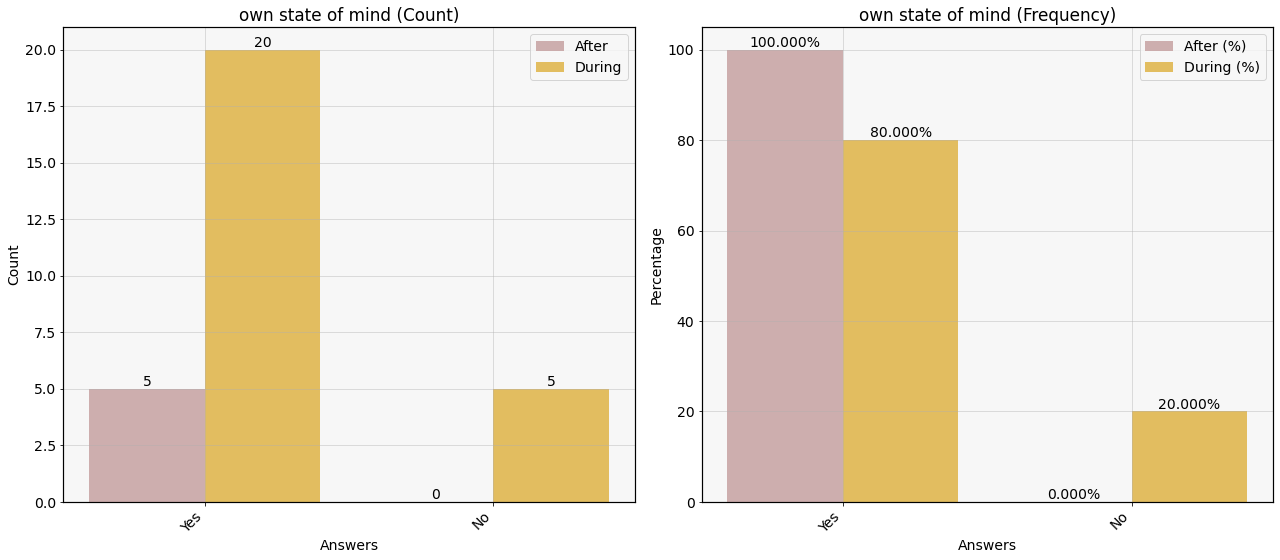

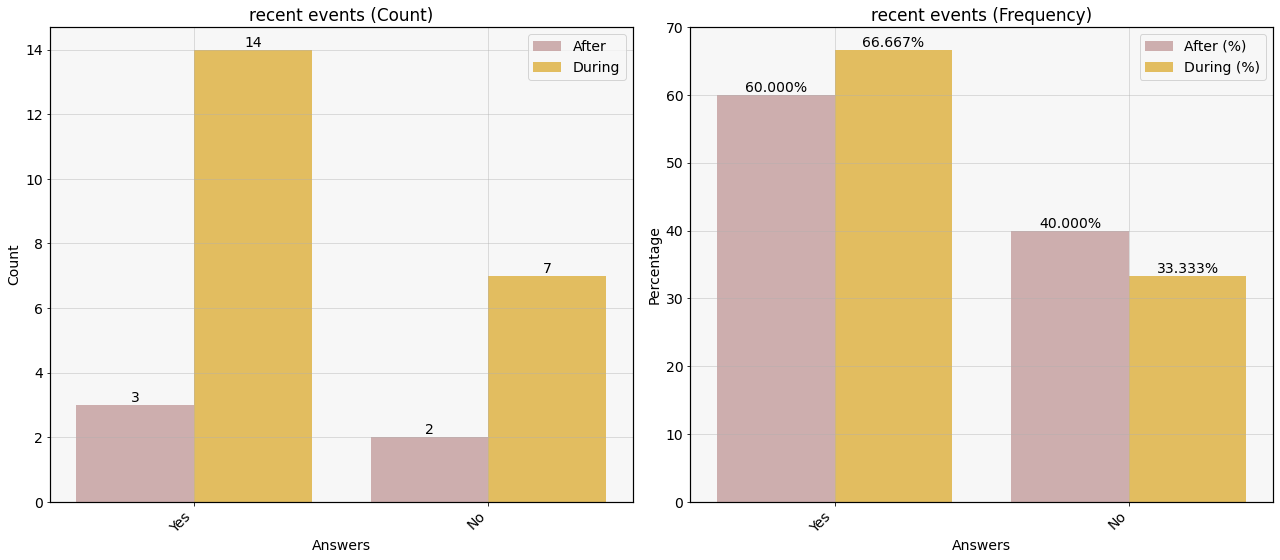

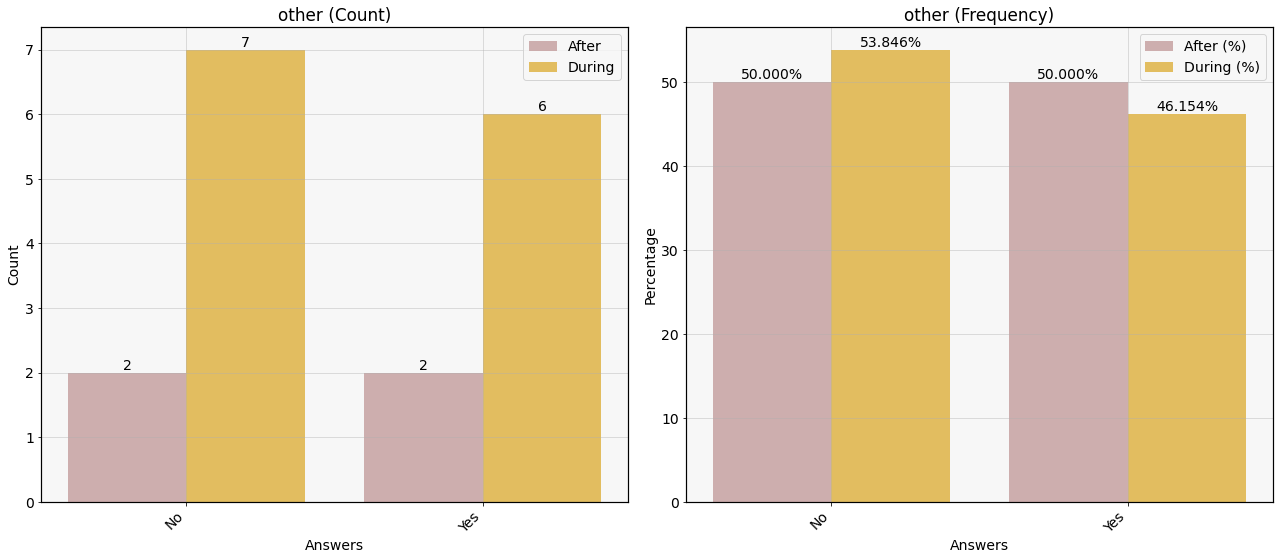

In [79]:
#context
for i, n in enumerate(['emotional','context', 'location', 'facilitators', 'other ppl actions', 'music', 'sensorial context', 'own state of mind','recent events','other']):
        compare_before_after_hist(final_data, i+52, i+101, title = n)

In [80]:
for i, n in enumerate(['location', 'facilitators', 'other ppl actions', 'music', 'sensorial context', 'own state of mind','recent events','other']):
    print(n)
    print('AFTER')
    print_answers(i+62)
    print('DURING')
    print_answers(i+111)
    print('\n')



location
AFTER
DURING


facilitators
AFTER
DURING


other ppl actions
AFTER
DURING


music
AFTER
DURING


sensorial context
AFTER
DURING


own state of mind
AFTER
DURING


recent events
AFTER
DURING


other
AFTER
DURING




#### Control

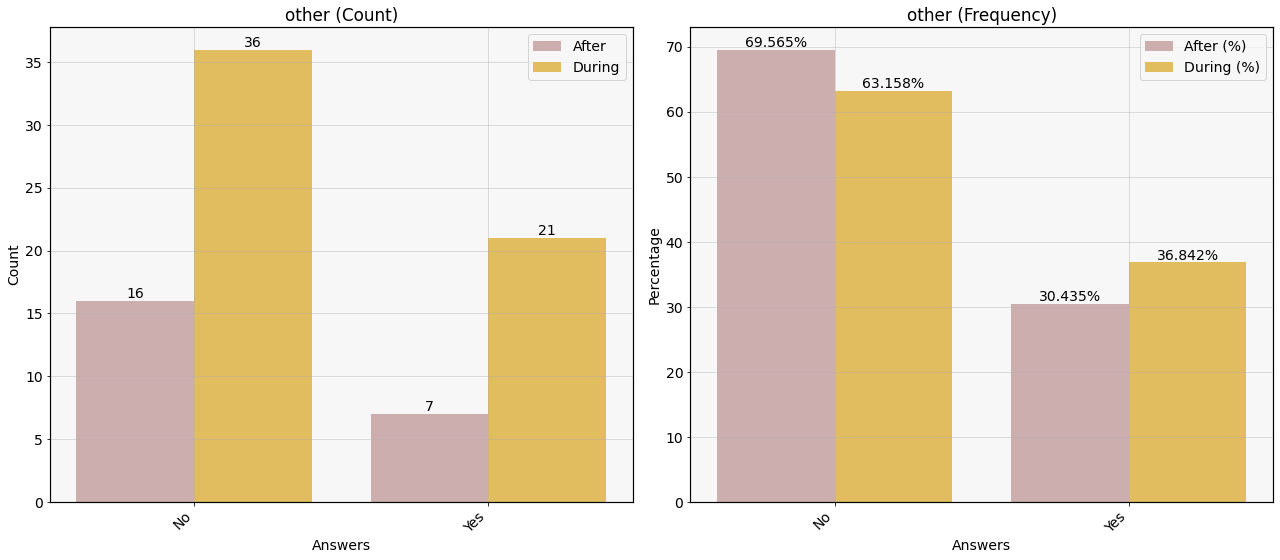

what features have changed
----------------- AFTER -------------
----------------- DURING-------------


In [81]:
#changes over time
compare_before_after_hist(final_data, 70, 119, title = 'other')
print('what features have changed')
print('----------------- AFTER -------------')
print_answers(71)
print('----------------- DURING-------------')
print_answers(120)

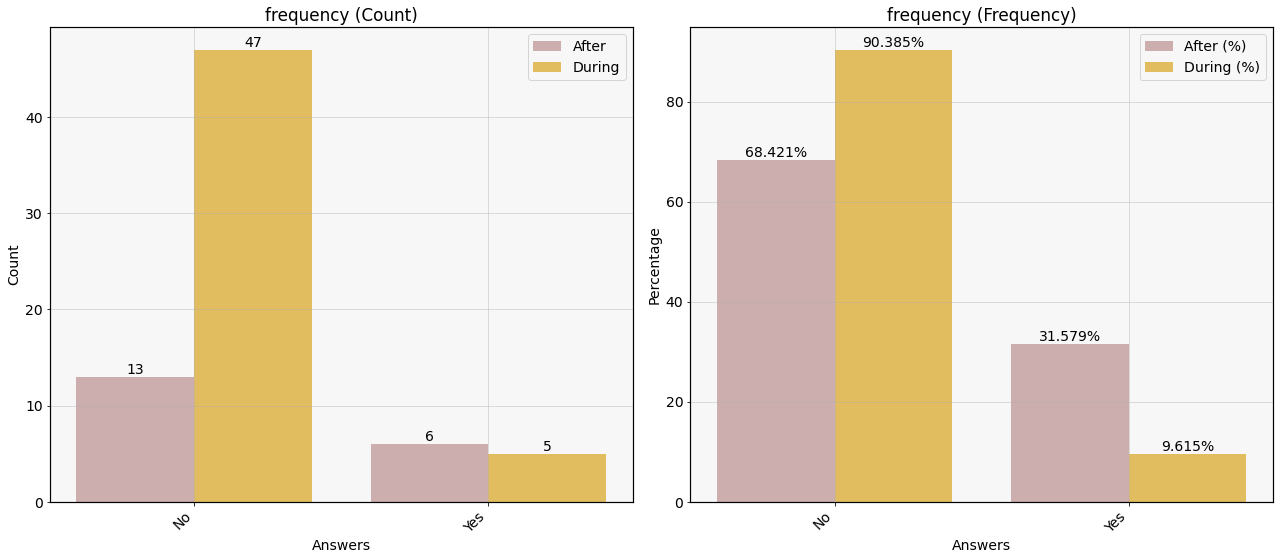

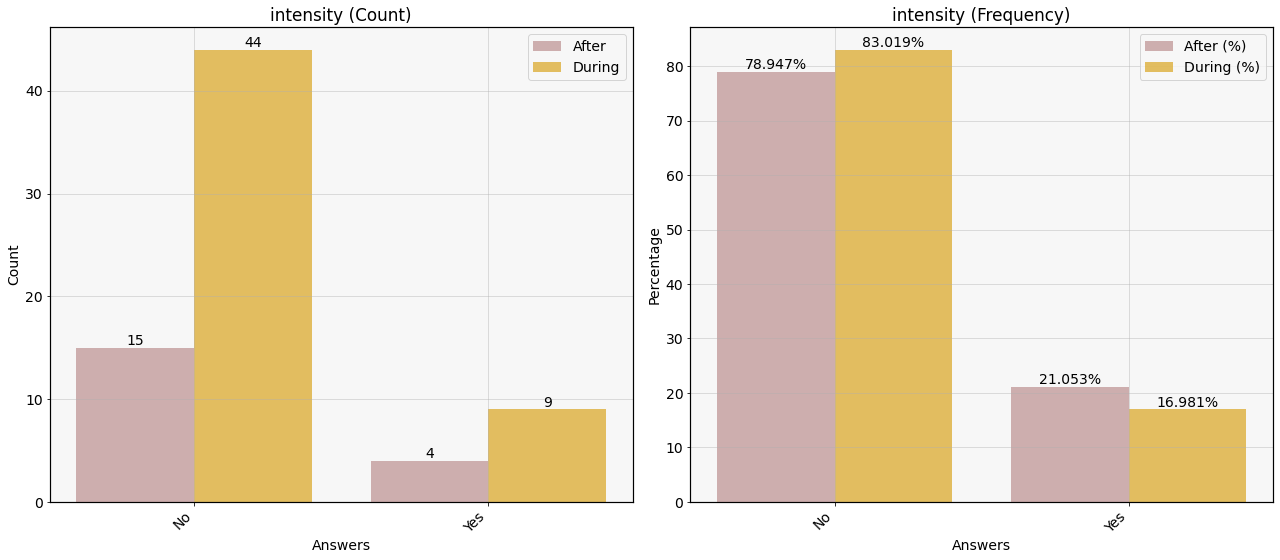

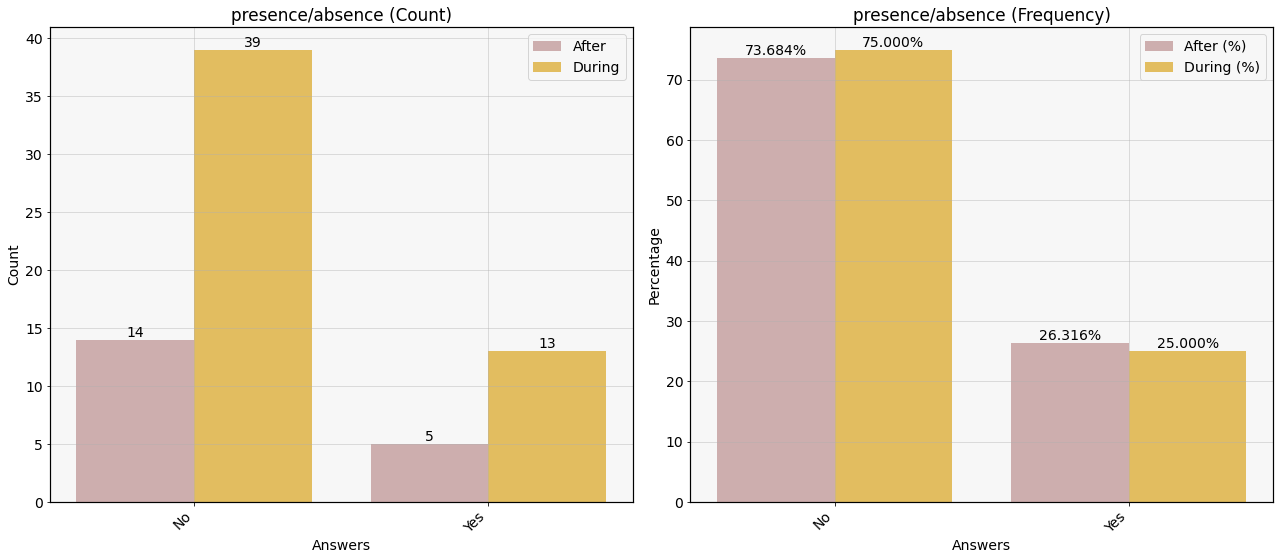

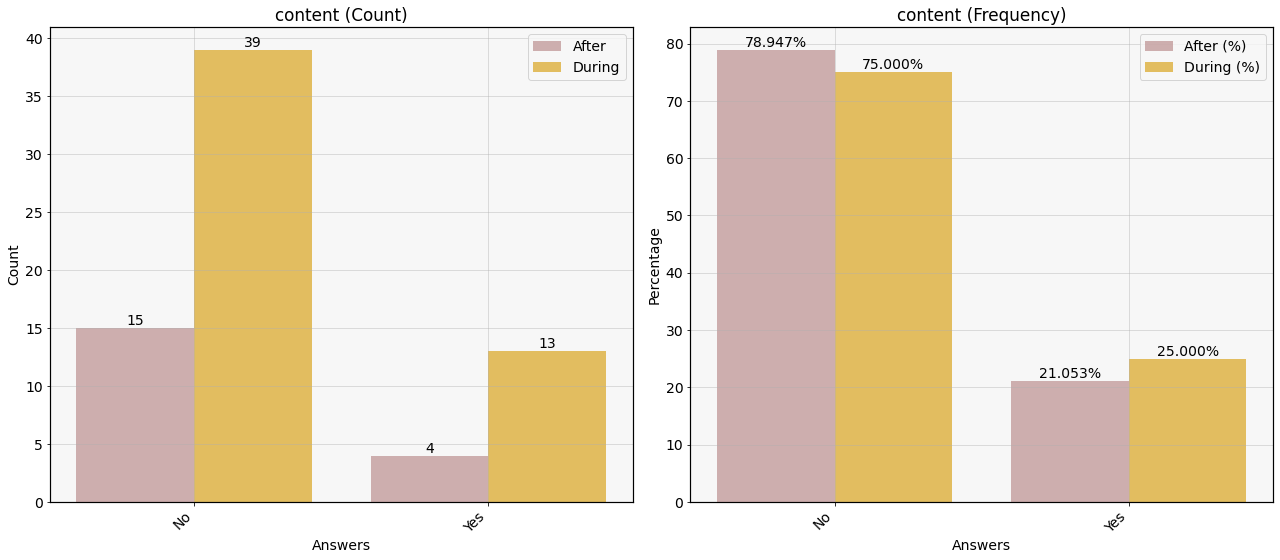

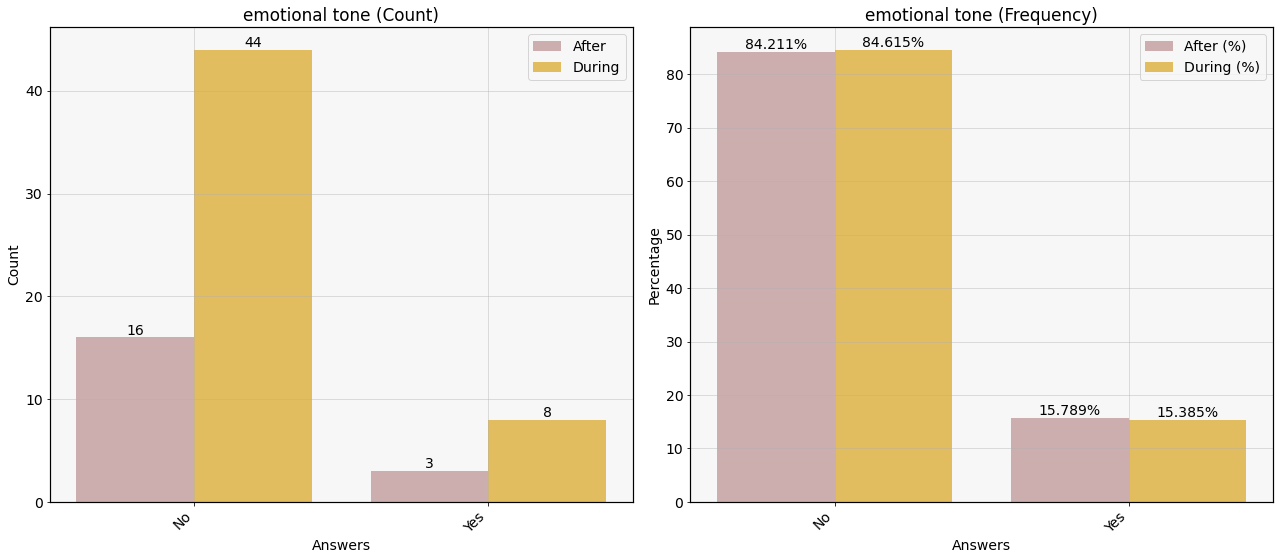

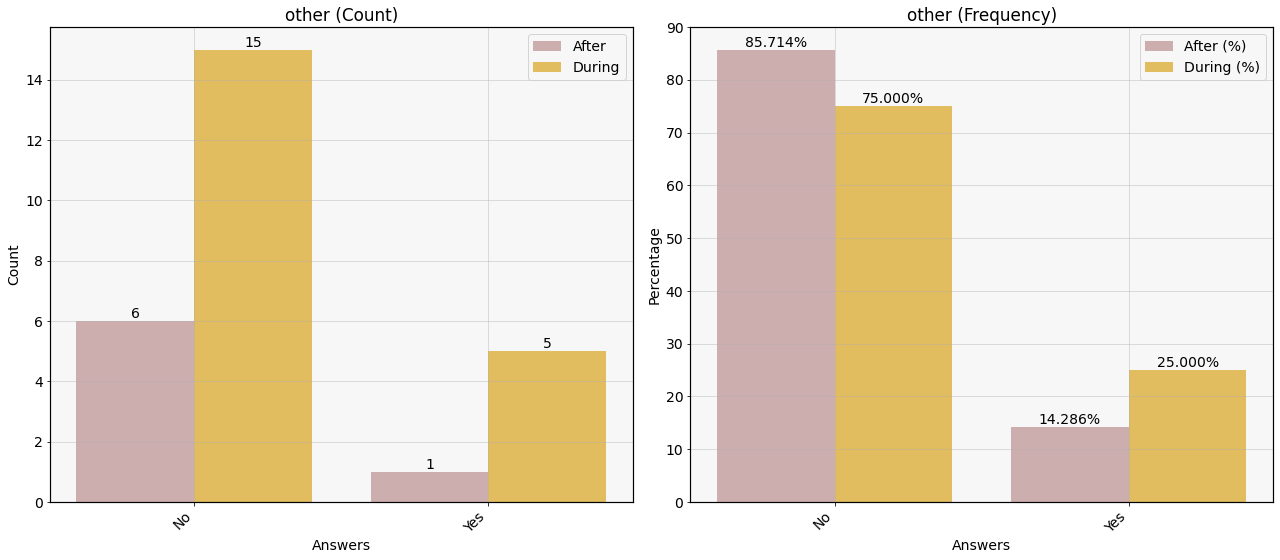

specify which other features you had control upon
------------------
HOW WAS CONTROL ACHIEVED


In [82]:
compare_before_after_hist(final_data, 72, 122, title = 'frequency')
compare_before_after_hist(final_data, 73, 123, title = 'intensity')
compare_before_after_hist(final_data, 74, 121, title = 'presence/absence')
compare_before_after_hist(final_data, 75, 124, title = 'content')
compare_before_after_hist(final_data, 76, 125, title = 'emotional tone')
compare_before_after_hist(final_data, 77, 126, title = 'other')

#control over other features? other
print('specify which other features you had control upon')
print_answers(78)
print_answers(127)
#control
print('------------------')
print('HOW WAS CONTROL ACHIEVED')
print_answers(79)
print_answers(128)

practice
--------------BEFORE------------
--------------DURING-------------

 purpose for hearing voices
--------------BEFORE------------
--------------DURING-------------


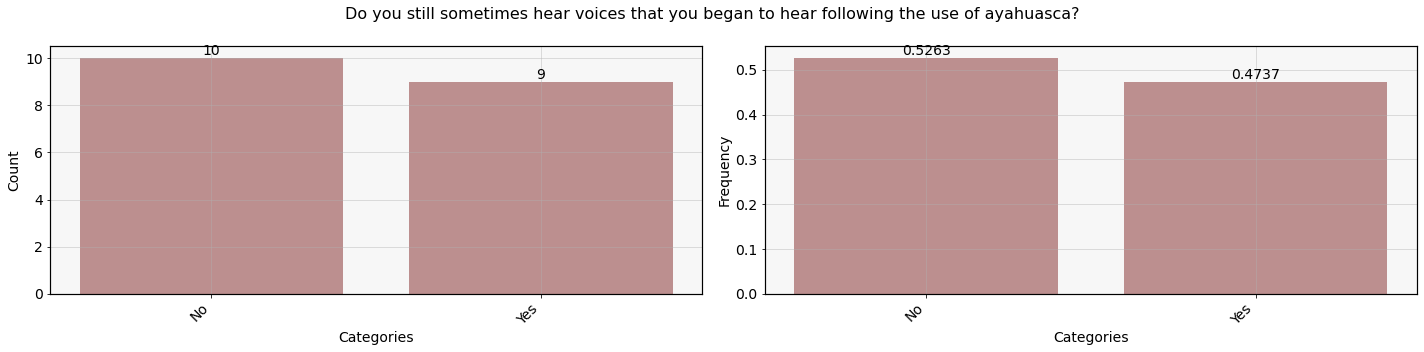

In [83]:
#other questions
print('practice')
print('--------------BEFORE------------')
print_answers(80)
print('--------------DURING-------------')
print_answers(129)
print('\n purpose for hearing voices')
print('--------------BEFORE------------')
print_answers(81)
print('--------------DURING-------------')
print_answers(130)
for i in [82]:
    plot_ordered_histogram(final_data, i, title = question_dict[i])

#### Quality of life

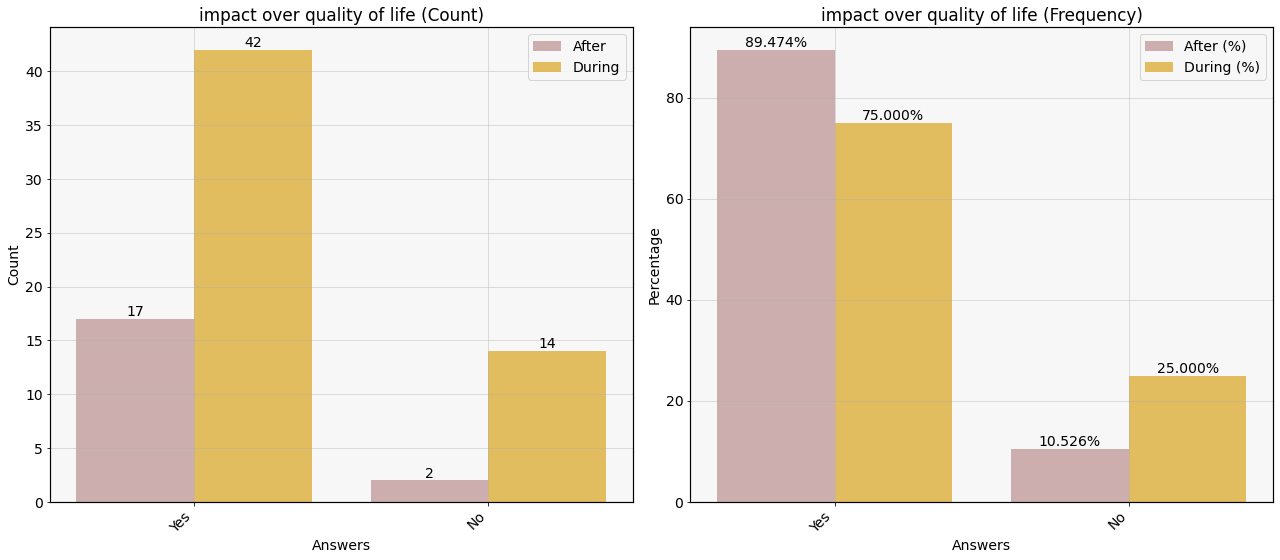

(Counter({'Yes': 17, 'No': 2}), Counter({'Yes': 42, 'No': 14}))

In [84]:
#quality of life
compare_before_after_hist(final_data, 83, 131, title = 'impact over quality of life')


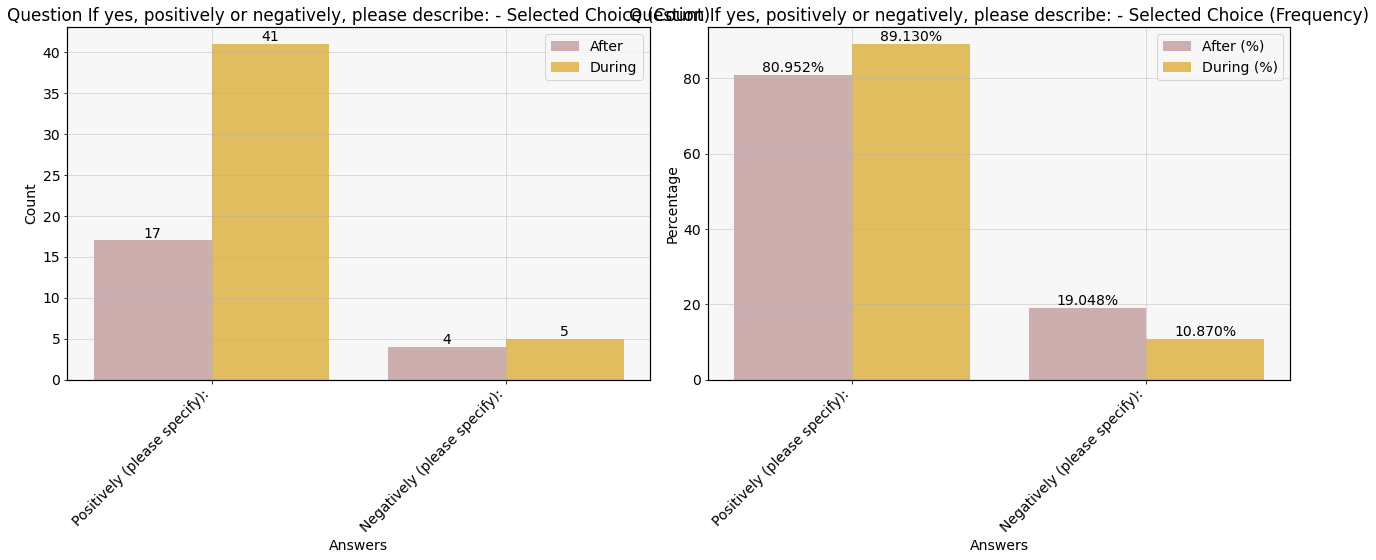

positively describe
---------- AFTER -------------
---------- DURING -------------
negatively describe
---------- AFTER -------------
---------- DURING -------------


In [85]:
compare_before_after_hist(final_data, 84, 132)

print('positively describe')
print('---------- AFTER -------------')
print_answers(85)
print('---------- DURING -------------')
print_answers(133)

print('negatively describe') #nothing here!! damn
print('---------- AFTER -------------')
print_answers(86)
print('---------- DURING -------------')
print_answers(134)

## Other

### TAS

In [102]:
#the TAS score is just the sum of 'True' for each participants
#filter who answered questions
rows_to_keep = final_data.iloc[:, 135:178].dropna(how='any').index
final_data_scores = final_data.loc[rows_to_keep]
print(len(final_data_scores.iloc[:,135:169]), 'participants completed the final questionnaires')

#compute TAS score
final_data_scores['TAS_SCORE'] = final_data_scores.apply(lambda row : row[135:169].value_counts(normalize = False).get('True', 1), axis=1)


59 participants completed the final questionnaires


In [103]:
final_data_scores['TAS_SCORE'].describe()
final_data_scores.to_csv('Data/clean_dataset_scales.csv', encoding = 'UTF-8', index= False)

In [104]:
mean_tas = final_data_scores['TAS_SCORE'].mean()
n_true = final_data_scores['TAS_SCORE'].sum()
n_tot = final_data_scores.shape[0]*34
std_tas = np.sqrt(np.sum((final_data_scores['TAS_SCORE']-mean_tas)**2)/( final_data_scores.shape[0]-1))
print(mean_tas, std_tas)

20.847457627118644 7.080360304785864


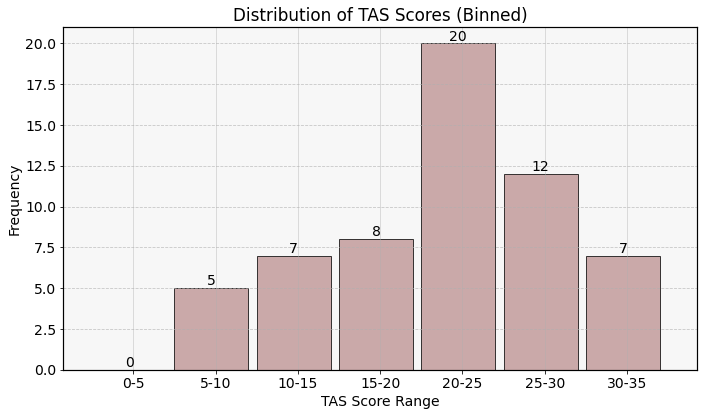

In [105]:
#check the frequency of VH in the ppl over 28

# Define bin edges for categories (0-5, 5-10, ..., 30-35)
bins = np.arange(0, 40, 5)  # 0, 5, 10, ..., 35

plt.figure(figsize=(10, 6))  # Set figure size

# Create histogram with defined bins
counts, edges, bars = plt.hist(final_data_scores['TAS_SCORE'], bins=bins, edgecolor="black", alpha=0.75, width=4.5)

# Add bar labels
plt.bar_label(bars)

# Set tick labels at the center of each bin
plt.xticks(bins[:-1] + 2.5, [f"{int(left)}-{int(right)}" for left, right in zip(bins[:-1], bins[1:])])

# Labels and title
plt.xlabel("TAS Score Range")
plt.ylabel("Frequency")
plt.title("Distribution of TAS Scores (Binned)")

# Show grid for clarity
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()



In [106]:
final_data_scores[final_data_scores['TAS_SCORE'] >= 28].iloc[:,24]

4      A few times
11           Never
17           Never
22     A few times
30           Never
40           Never
75      Many times
126     Many times
Name: Q23, dtype: object

In [107]:
#comparing with data from the lit (Glisky et al. 1991,study 1)
from scipy.stats import wilcoxon

sample_data = final_data_scores['TAS_SCORE'].dropna()
literature_mean = 20.29
    
# Compute differences from literature mean
differences = sample_data - literature_mean

# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(differences)

# Print results
print(f"Wilcoxon Statistic: {stat:.3f}")
print(f"P-Value: {p_value:.5f}")



Wilcoxon Statistic: 772.000
P-Value: 0.39351


In [108]:
import scipy.stats as stats

# Data for the group with raw data (replace with your actual data)
sample_data = final_data_scores['TAS_SCORE'].dropna()  # Example data

# Summary statistics for the group with only mean and std (replace with your actual values)
known_mean = 20.54 # Mean of the other group

# Calculate sample mean and standard deviation
sample_mean = sum(sample_data) / len(sample_data)
sample_std = (sum([(x - sample_mean)**2 for x in sample_data]) / (len(sample_data)-1))**0.5 # or use np.std(sample_data, ddof=1) if you use numpy
n = len(sample_data)  # Sample size

# Perform the one-sample t-test
t_statistic, p_value = stats.ttest_1samp(sample_data, known_mean)

# Print the results
print("Sample Mean:", sample_mean)
print("Sample Standard Deviation:", sample_std)
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Interpret the p-value (example)
alpha = 0.05  # Significance level
if p_value < alpha:
    print("The means are significantly different.")
else:
    print("The means are not significantly different.")


# Example using numpy for std calculation (recommended)
import numpy as np
sample_std_np = np.std(sample_data, ddof=1) # ddof=1 for sample standard deviation

print("\nUsing numpy for std:")
print("Sample Standard Deviation (numpy):", sample_std_np)

Sample Mean: 20.847457627118644
Sample Standard Deviation: 7.080360304785865
T-statistic: 0.3335461393957369
P-value: 0.739924944830149
The means are not significantly different.

Using numpy for std:
Sample Standard Deviation (numpy): 7.080360304785865


## Hallucination scale (LHSH-R, McCarthy-Jones & Fernyhough,2011)

### functions

In [109]:
def plot_ordered_histogram(df, col, rotate_labels=True, figsize=(10, 5), labels=None, title=None):
    """
    Plots both a count and a frequency histogram for a categorical column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    col (int or str): The column index or name.
    rotate_labels (bool): Whether to rotate x-axis labels for better visibility.
    figsize (tuple): Figure size in inches (width, height).
    
    Returns:
    None
    """
    # Drop NaN values from the column
    valid_data = df.iloc[:, col].dropna()

    # Convert to categorical with sorted order
    if labels is None:
        labels = sorted(valid_data.unique())
    valid_data = pd.Categorical(valid_data, categories=labels, ordered=True)

    # Count occurrences
    counts = valid_data.value_counts().reindex(valid_data.categories, fill_value=0)
    frequencies = counts / counts.sum()  # Normalize to get frequencies

    # Set up figure with two subplots (Counts and Frequency)
    fig, axes = plt.subplots(1, 2, figsize=(figsize[0] * 2, figsize[1]))

    # Plot raw counts
    bars = axes[0].bar(counts.index, counts.values)
    axes[0].bar_label(bars)
    axes[0].set_xlabel("Categories")
    axes[0].set_ylabel("Count")
    axes[0].set_title(title if title else f"Counts for Question {col}")

    # Plot frequencies
    bars_freq = axes[1].bar(frequencies.index, frequencies.values)
    axes[1].bar_label(bars_freq, fmt="%.2f")  # Show 2 decimal places
    axes[1].set_xlabel("Categories")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title(title if title else f"Frequency for Question {col}")

    # Rotate labels if needed
    if rotate_labels:
        for ax in axes:
            ax.set_xticks(range(len(labels)))
            ax.set_xticklabels(labels, rotation=45, ha="right")

    # Show plot
    plt.tight_layout()
    plt.show()


In [110]:
def analyze_likert(df, col):
    """
    Analyzes a 4-point Likert scale question: computes mean, std, and frequency counts.

    Parameters:
    df (pd.DataFrame): DataFrame containing survey responses.
    col (int or str): Column index or name with Likert scale responses.

    Returns:
    dict: Mean, std, and frequency distribution.
    """
    # Drop NaN values
    data = df.iloc[:, col].dropna()

    # Convert categorical responses to numerical values if necessary
    mapping = {'Never' : 1 , 'Sometimes' : 2 , 'Almost Always' : 3, 'Always' : 4}
    if data.dtype == 'object':
        data = data.map(mapping)

    # Compute statistics
    mean = data.mean()
    std = data.std()
    freq_counts = data.value_counts().sort_index()  # Count responses in order

    # Print results
    print(f"📊 **Analysis for Question: {question_dict[col].split('-')[-1]}**")
    print(f"Mean Score: {mean:.2f}")
    print(f"Standard Deviation: {std:.2f}")
    print("\nFrequency Distribution:")
    print(freq_counts)

    return {"mean": mean, "std": std, "frequencies": freq_counts}

# Example Usage:
# analyze_likert(df, "Q1")  # Replace "Q1" with your column name


### Analysis

📊 **Analysis for Question:  I hear a voice speaking my thoughts aloud.**
Mean Score: 1.41
Standard Deviation: 0.67

Frequency Distribution:
1.0    35
2.0    11
3.0     5
Name: Q109_1, dtype: int64


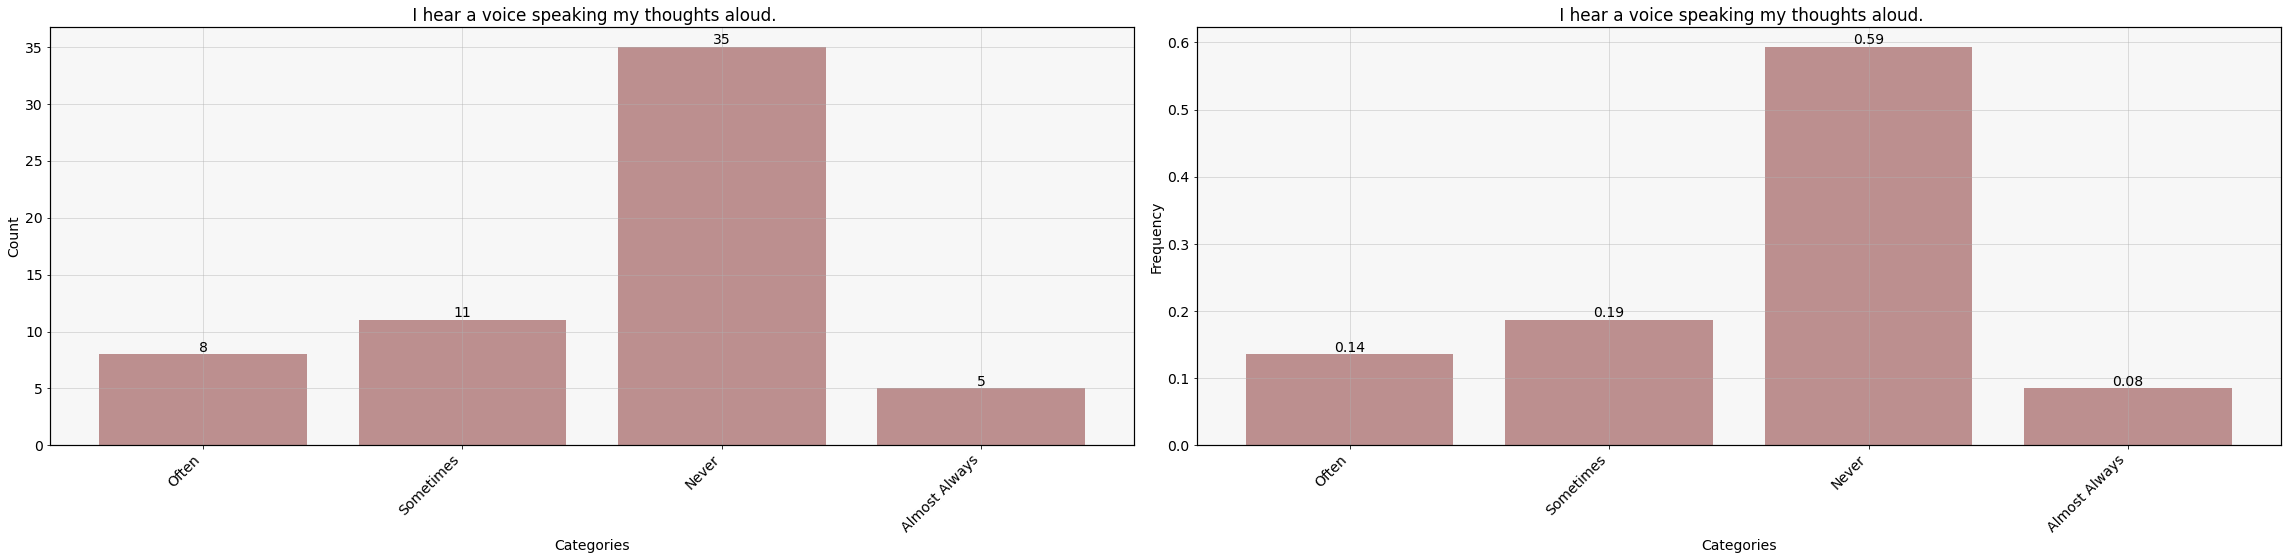

📊 **Analysis for Question:  I hear the telephone ring and find that I am mistaken.**
Mean Score: 1.33
Standard Deviation: 0.47

Frequency Distribution:
1.0    39
2.0    19
Name: Q109_2, dtype: int64


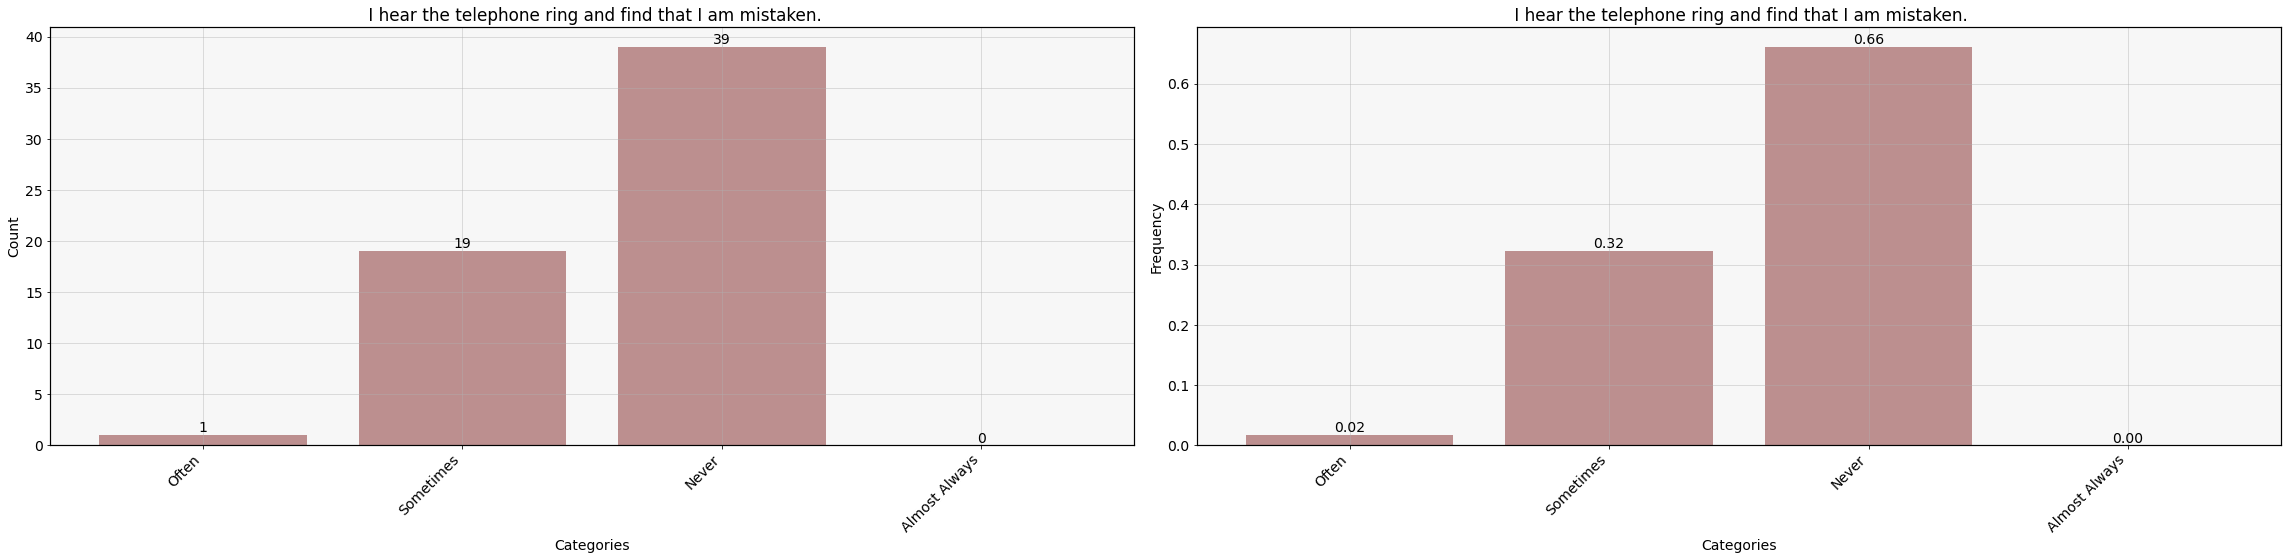

📊 **Analysis for Question:  I hear people call my name and find that nobody has done so.**
Mean Score: 1.50
Standard Deviation: 0.54

Frequency Distribution:
1.0    30
2.0    27
3.0     1
Name: Q109_3, dtype: int64


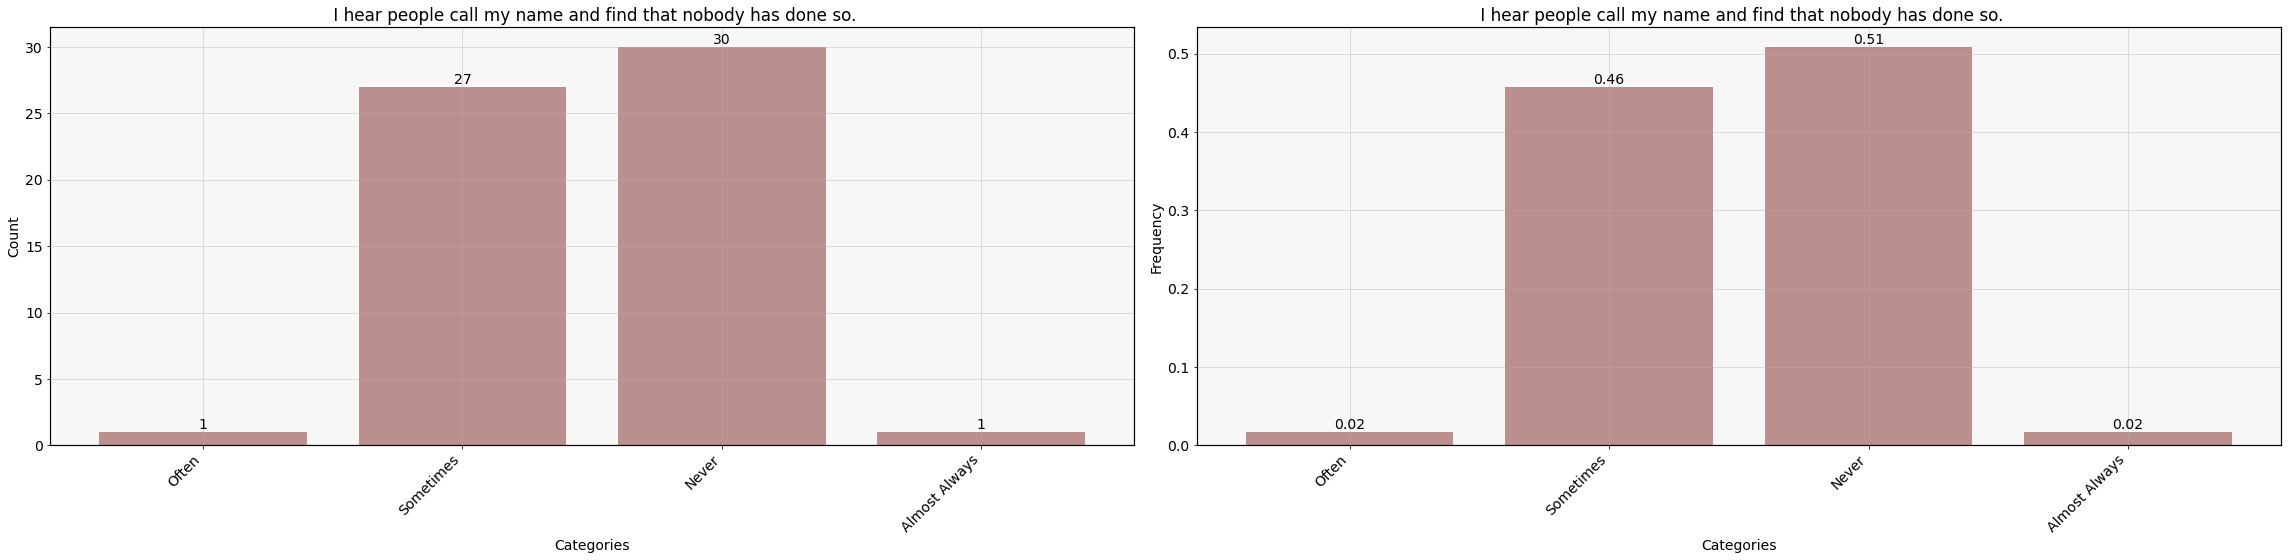

📊 **Analysis for Question:  I can hear music when it is not being played.**
Mean Score: 1.55
Standard Deviation: 0.61

Frequency Distribution:
1.0    25
2.0    21
3.0     3
Name: Q109_4, dtype: int64


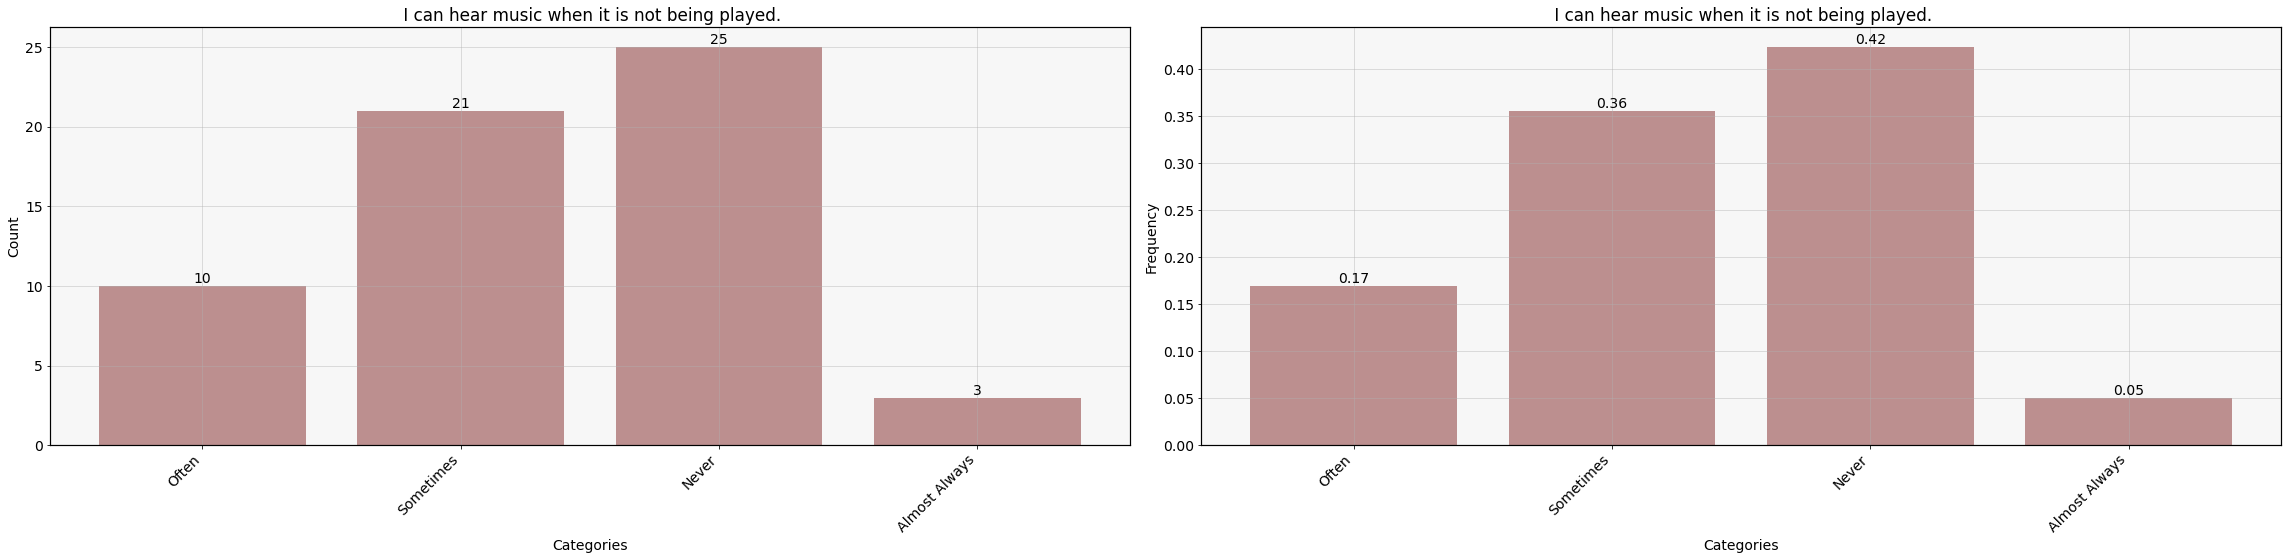

📊 **Analysis for Question:  I have had the experience of hearing a person’s voice and then found that no one was there.**
Mean Score: 1.39
Standard Deviation: 0.49

Frequency Distribution:
1.0    35
2.0    22
Name: Q109_5, dtype: int64


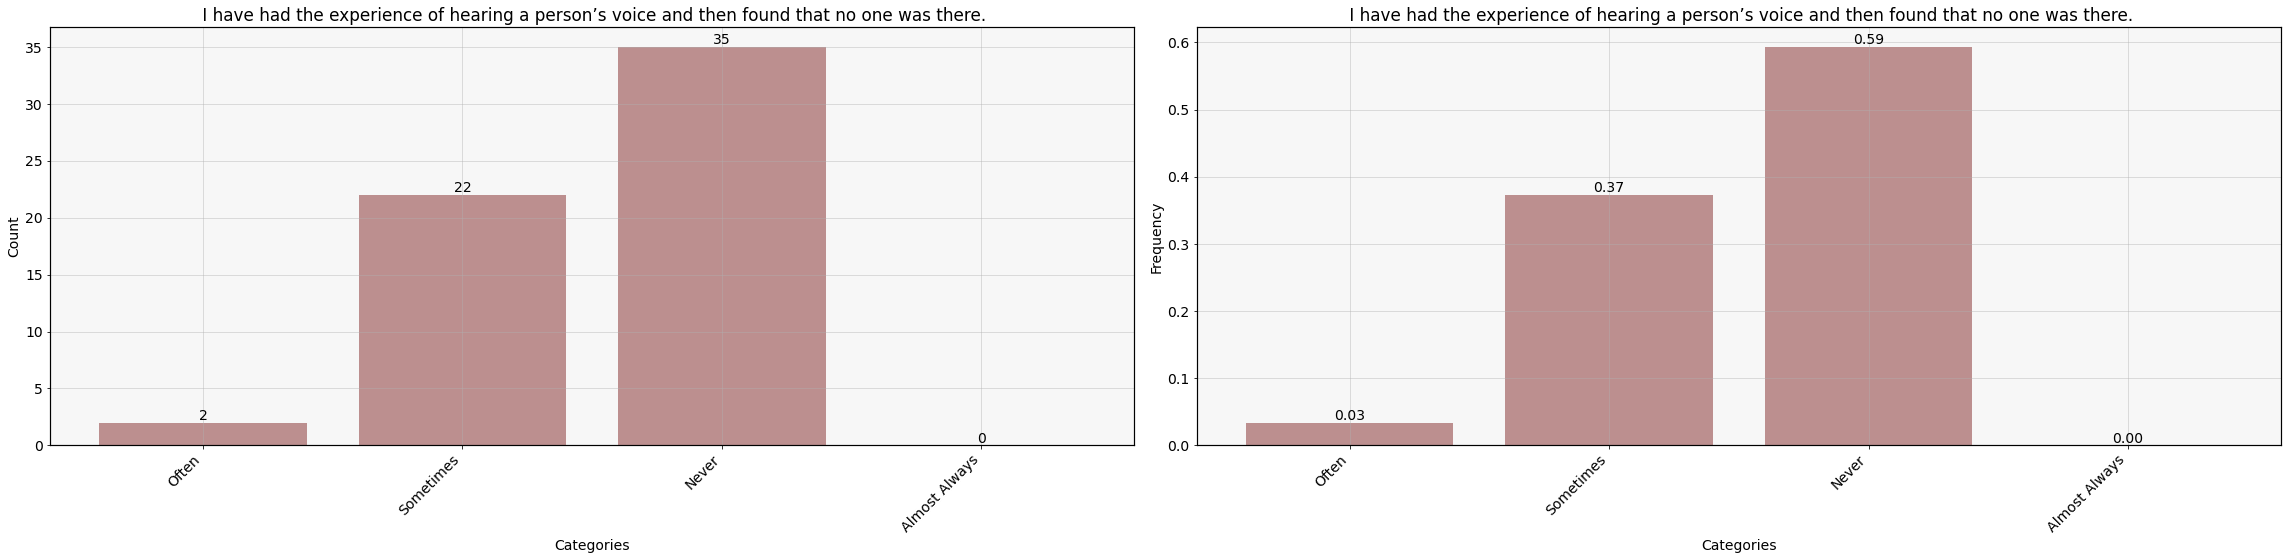

📊 **Analysis for Question:  When I look at things they look unreal to me.**
Mean Score: 1.36
Standard Deviation: 0.48

Frequency Distribution:
1.0    36
2.0    20
Name: Q109_6, dtype: int64


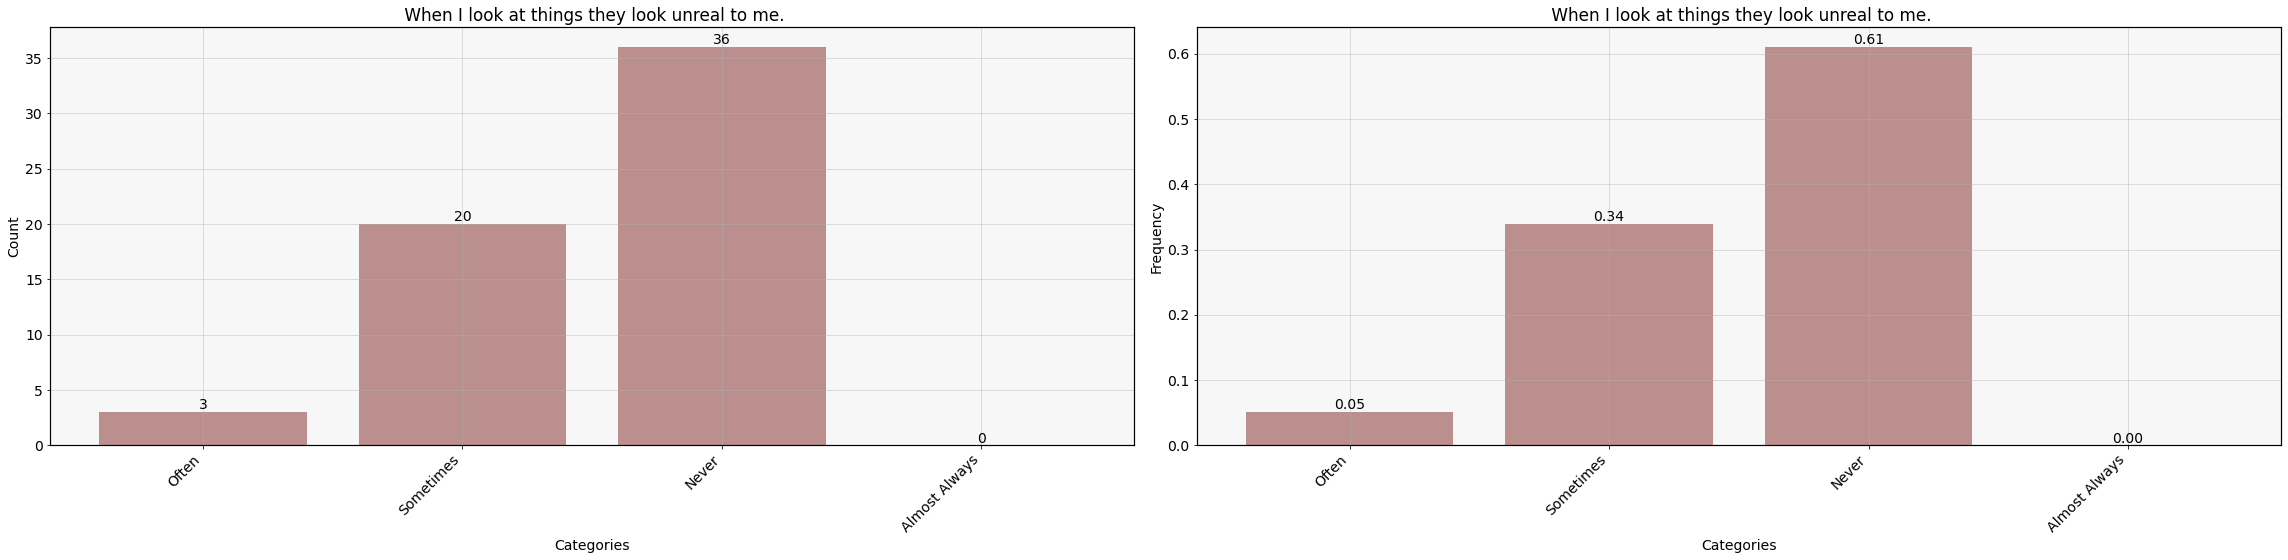

📊 **Analysis for Question:  I see shadows and shapes when nothing is there.**
Mean Score: 1.30
Standard Deviation: 0.50

Frequency Distribution:
1.0    40
2.0    15
3.0     1
Name: Q109_7, dtype: int64


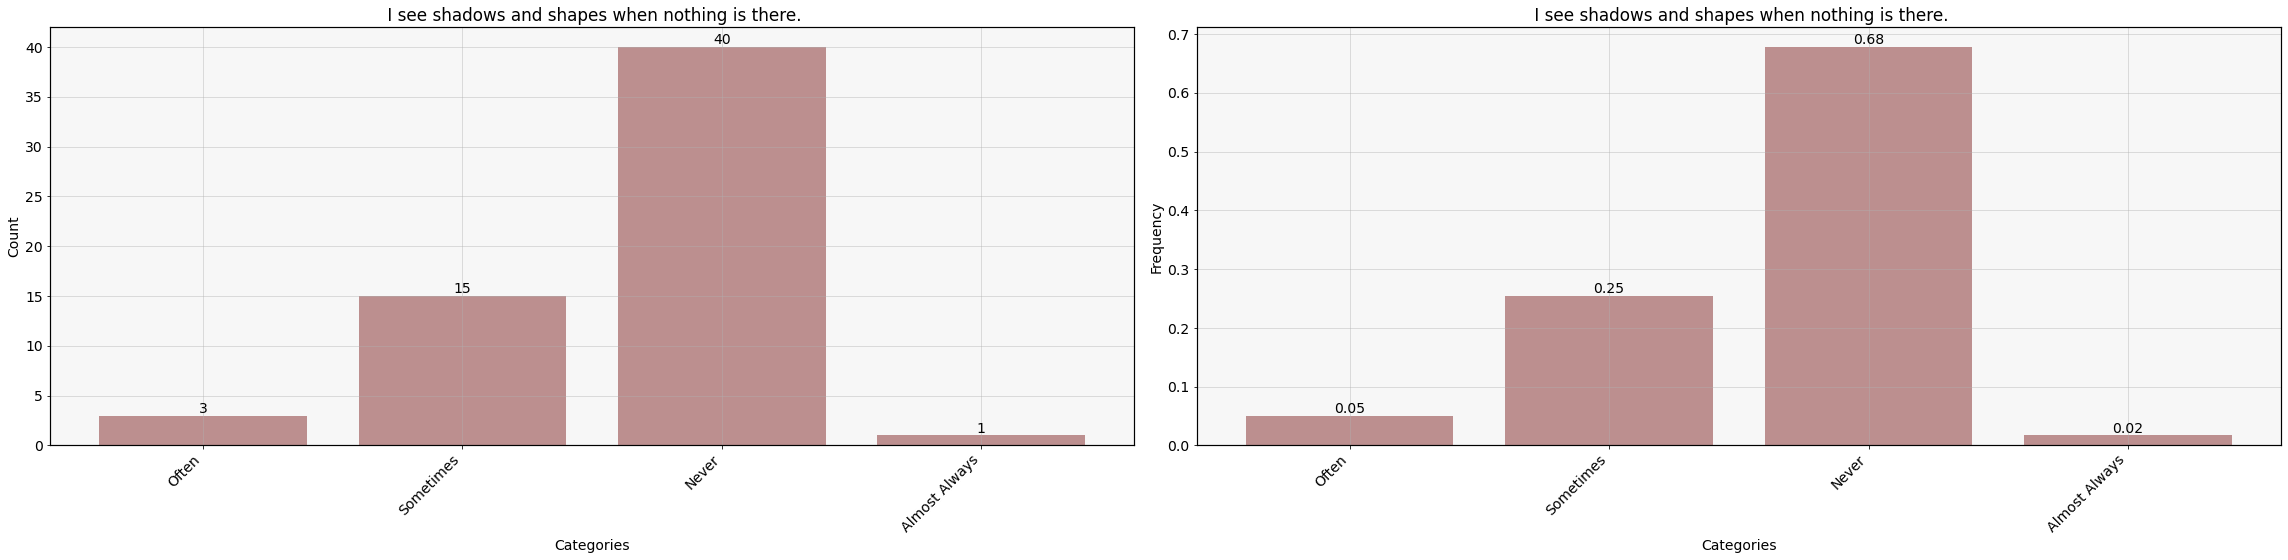

📊 **Analysis for Question:  When I look at myself in the mirror, I look different.**
Mean Score: 1.49
Standard Deviation: 0.50

Frequency Distribution:
1.0    26
2.0    25
Name: Q109_8, dtype: int64


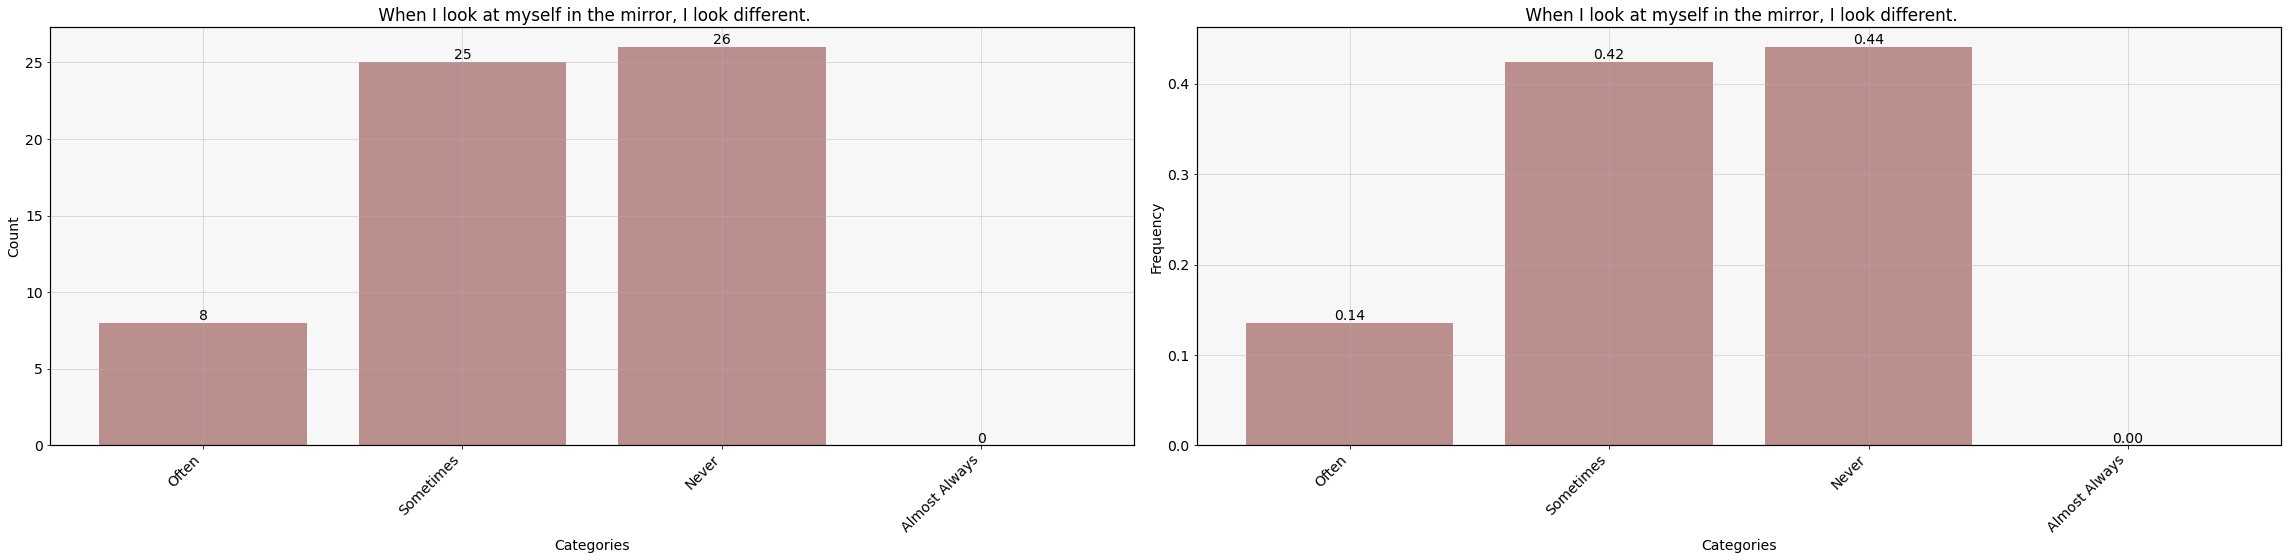

📊 **Analysis for Question:  When I look at things, they appear strange to me.**
Mean Score: 1.40
Standard Deviation: 0.49

Frequency Distribution:
1.0    35
2.0    23
Name: Q109_9, dtype: int64


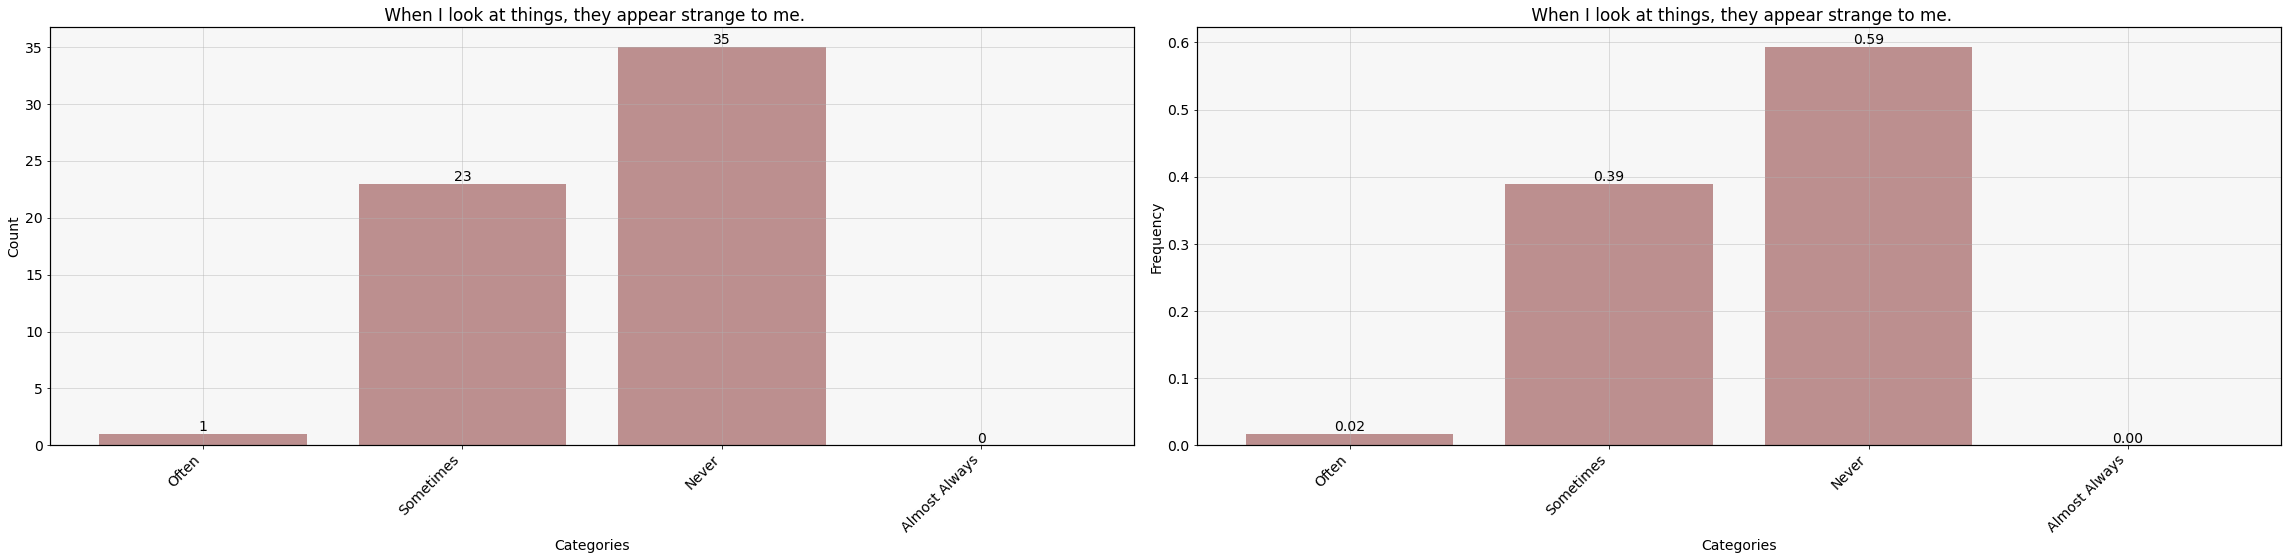

In [116]:
for i in range(169,178):
    analyze_likert(final_data_scores,i)
    plot_ordered_histogram(final_data_scores, i, title= question_dict[i].split("-")[-1], figsize = (16,8), labels = {'Never', 'Sometimes', 'Often', 'Almost Always'} )

# Output questions

In [ ]:
# Select columns: ResponseId + all columns in list_written_answers
df_selected = final_data[['ResponseId'] + [final_data.columns[i] for i in list_written_answers]].copy()

# Rename columns using list_written_answers mapping
new_column_names = ['ResponseId'] + [question_dict[i] for i in list_written_answers]  # Use question_dict for full names
df_selected.columns = new_column_names  # Rename columns

# Display the new DataFrame
#df_selected.head()

In [ ]:
df_selected.to_csv('DATA/questions_a_coder.csv',encoding='utf-8-sig', index= False)

# to delete:

In [ ]:
    # Append to file instead of overwriting
    with open(f'written_answers_all{NOW}.txt', 'a', newline='') as myfile:  # Use 'a' for append mode
        myfile.write(f'\n--------{question_dict[col]}-----------\n')  # Add section header
        #write other info: part. number
        [myfile.write(emoji_pattern.sub(r'', i) + '\n \n') for i in list(final_data.iloc[:, col].dropna())]  # Add line breaks